In [6]:
#check erosion/deposition inside meadows - relative change
#depth changes seasonal
from netCDF4 import Dataset
import numpy as  np
import matplotlib.pyplot as plt
from datetime import datetime

import math
import glob
import os.path
import sys
sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import read_data, sort_files
import h5py
import os.path

from matplotlib import rcParams
rcParams['figure.dpi'] = 300

import matplotlib as mpl
mpl.rc('hatch', color='k', linewidth=1)

In [7]:
#input
basename1 = 'srm021'
basename2 = 'srm020'#reference
simpat = '/work/gg0877/g260204/sim_data/SR5yr/'
season = 'aug'
mon = 8

svmin = -75
svmax = 75
dmin = -50
dmax = 50
dx = 0.025
outpath = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/srm02x/21_ref20/'

if not os.path.exists(outpath):
    os.makedirs(outpath)

In [8]:
#read velocity data

v1  = np.zeros(48883)
v2  = np.zeros(48883)
n1 = 0
n2 = 0

for year in range(2010,2016):
    #pname = 'srm023_erodep'
    simname1 = basename1 + '_' + str(year)
    simname2 = basename2 + '_' + str(year)
    hdf5file1 = '/work/gg0877/g260204/data/pickle_files/' +simname1 + '_mean_vel_bot_'+season+'.hdf5'
    hdf5file2 = '/work/gg0877/g260204/data/pickle_files/' +simname2 + '_mean_vel_bot_'+season+'.hdf5'

    if os.path.isfile(hdf5file1):    
        print('read from file:', simname1)
        f = h5py.File(hdf5file1,'r')
        v1 += np.sqrt(f['x_mean'][:]**2+f['y_mean'][:]**2)
        n1 += 1
        f.close()
    if os.path.isfile(hdf5file2):    
        print('read from file:', simname2)
        f = h5py.File(hdf5file2,'r')
        v2 += np.sqrt( f['x_mean'][:]**2+f['y_mean'][:]**2)
        n2 +=1
        f.close()    

v1 = v1/n1
v2 = v2/n2

read from file: srm021_2010
read from file: srm020_2010
read from file: srm021_2011
read from file: srm020_2011
read from file: srm021_2012
read from file: srm020_2012
read from file: srm021_2013
read from file: srm020_2013
read from file: srm021_2014
read from file: srm020_2014
read from file: srm021_2015
read from file: srm020_2015


In [9]:
#read depth data
doy = datetime(2010,mon,1).timetuple().tm_yday
dch1  = np.zeros(48883)
dch2  = np.zeros(48883)
n = 0

for year in range(2010,2016):
    simname1 = basename1 + '_' + str(year)
    simname2 = basename2 + '_' + str(year)
    ncpat1_s = simpat + simname1 + '/outputs/schout_' + str(doy) +'.nc'
    ncpat1_e = simpat + simname1 + '/outputs/schout_' + str(doy+30) +'.nc'
    ncpat2_s = simpat + simname2 + '/outputs/schout_' + str(doy) +'.nc'
    ncpat2_e = simpat + simname2 + '/outputs/schout_' + str(doy+30) +'.nc'
    
    #read data1
    ncdata1_s = Dataset(ncpat1_s,mode='r')
    ncdata1_e = Dataset(ncpat1_e,mode='r')
    start = ncdata1_s.variables['SED_depth_change'][-1,:]
    end = ncdata1_e.variables['SED_depth_change'][-1,:]
    dch1 += end-start
    
    #read data2 
    ncdata2_s = Dataset(ncpat2_s,mode='r')
    ncdata2_e = Dataset(ncpat2_e,mode='r')
    start = ncdata2_s.variables['SED_depth_change'][-1,:]
    end = ncdata2_e.variables['SED_depth_change'][-1,:]
    dch2 += end-start
    n += 1

dch1 = dch1/n
dch2 = dch2/n

#read time independent data
x       = ncdata1_s.variables['SCHISM_hgrid_node_x'][:]
y       = ncdata1_s.variables['SCHISM_hgrid_node_y'][:]
tri     = ncdata1_s.variables['SCHISM_hgrid_face_nodes'][:,:3]-1
depth   = ncdata1_s.variables['depth'][:]

In [10]:
#relative change (new-old)/old *100
delta = -(dch1-dch2)/abs(dch2) *100
delta[~np.isfinite(delta)]= 0 # remove errors from deviding by 0

deltav = (v1-v2)/abs(v2) *100 
deltav[~np.isfinite(deltav)] = 0

/tmp/ipykernel_323035/3394999456.py:5: RuntimeWarning: invalid value encountered in divide
  deltav = (v1-v2)/abs(v2) *100


-0.20133690039316812

In [6]:
#seagras meadows
import geopandas as gpd
sg_de_pat = '/work/gg0877/g260204/sim_data/SyltRomo/01_preprog/100m2014/seegrass_2014_DE.shp'
sg_dk_pat = '/work/gg0877/g260204/sim_data/SyltRomo/01_preprog/100m2014/seegrass_2014_DK.shp'
shp_pat =  '/work/gg0877/g260204/sim_data/SyltRomo/01_preprog/100m/syltromo_silhouette.shp'
sg_de = gpd.read_file(sg_de_pat)
sg_dk = gpd.read_file(sg_dk_pat)
sg_de = sg_de.to_crs("EPSG:4326")
sg_dk = sg_dk.to_crs("EPSG:4326")
sg_de = sg_de.cx[:,54.885:]
sg_dk = sg_dk.cx[:,:55.14]
#    sg_de.boundary.plot(ax=plt.gca(),color='red',linewidth=0.5)
#    sg_dk.boundary.plot(ax=plt.gca(),color='red',linewidth=0.5)

In [7]:
#### split danish seagrass into subsections
sg_havn = sg_dk[sg_dk['Område']=='Havneby Nord']
sg_havs = sg_dk[sg_dk['Område']=='Havneby Syd']
sg_kold = sg_dk[sg_dk['Område']=='Koldby']
sg_ball = sg_dk[sg_dk['Område']=='Ballum']
sg_jord = sg_dk[sg_dk['Område']=='Jordsand']

In [8]:
#split german seagrass into subsections
sg_rick = sg_de[3:9]
sg_hind = sg_de[9:13]
sg_mors = sg_de[13:15]
sg_keit = sg_de[15:24]
sg_kamp = sg_de.iloc[[2,24]]
sg_koen = sg_de.iloc[[0,1,25,26]]

In [9]:
import shapely
#find center point of meadow
def center(geo):
    bnd = geo.geometry.total_bounds
    print(bnd[2]-bnd[0], bnd[3]-bnd[1])
    return [(bnd[2]+bnd[0])/2 ,(bnd[1]+bnd[3])/2]

c_havn = center(sg_havn)
c_havs = center(sg_havs)
c_kold = center(sg_kold)
c_ball = center(sg_ball)
c_jord = center(sg_jord)
c_rick = center(sg_rick)
c_hind = center(sg_hind)
c_mors = center(sg_mors)
c_keit = center(sg_keit)
c_kamp = center(sg_kamp)
c_koen = center(sg_koen)

0.009694914479577932 0.017461734130868933
0.023382769894826794 0.011623981083211277
0.02998527828615849 0.01952151657220469
0.024094545318520844 0.05204716672643883
0.029977929856803698 0.010280023968668672
0.04901145463458256 0.03712430613522599
0.0563277533358395 0.005867205841127543
0.036077017019851 0.007069526419648753
0.05754485601813819 0.0338535869572425
0.005957891832489182 0.032694937947709946
0.040757727943219635 0.02298351093101303


(54.8, 55.2)

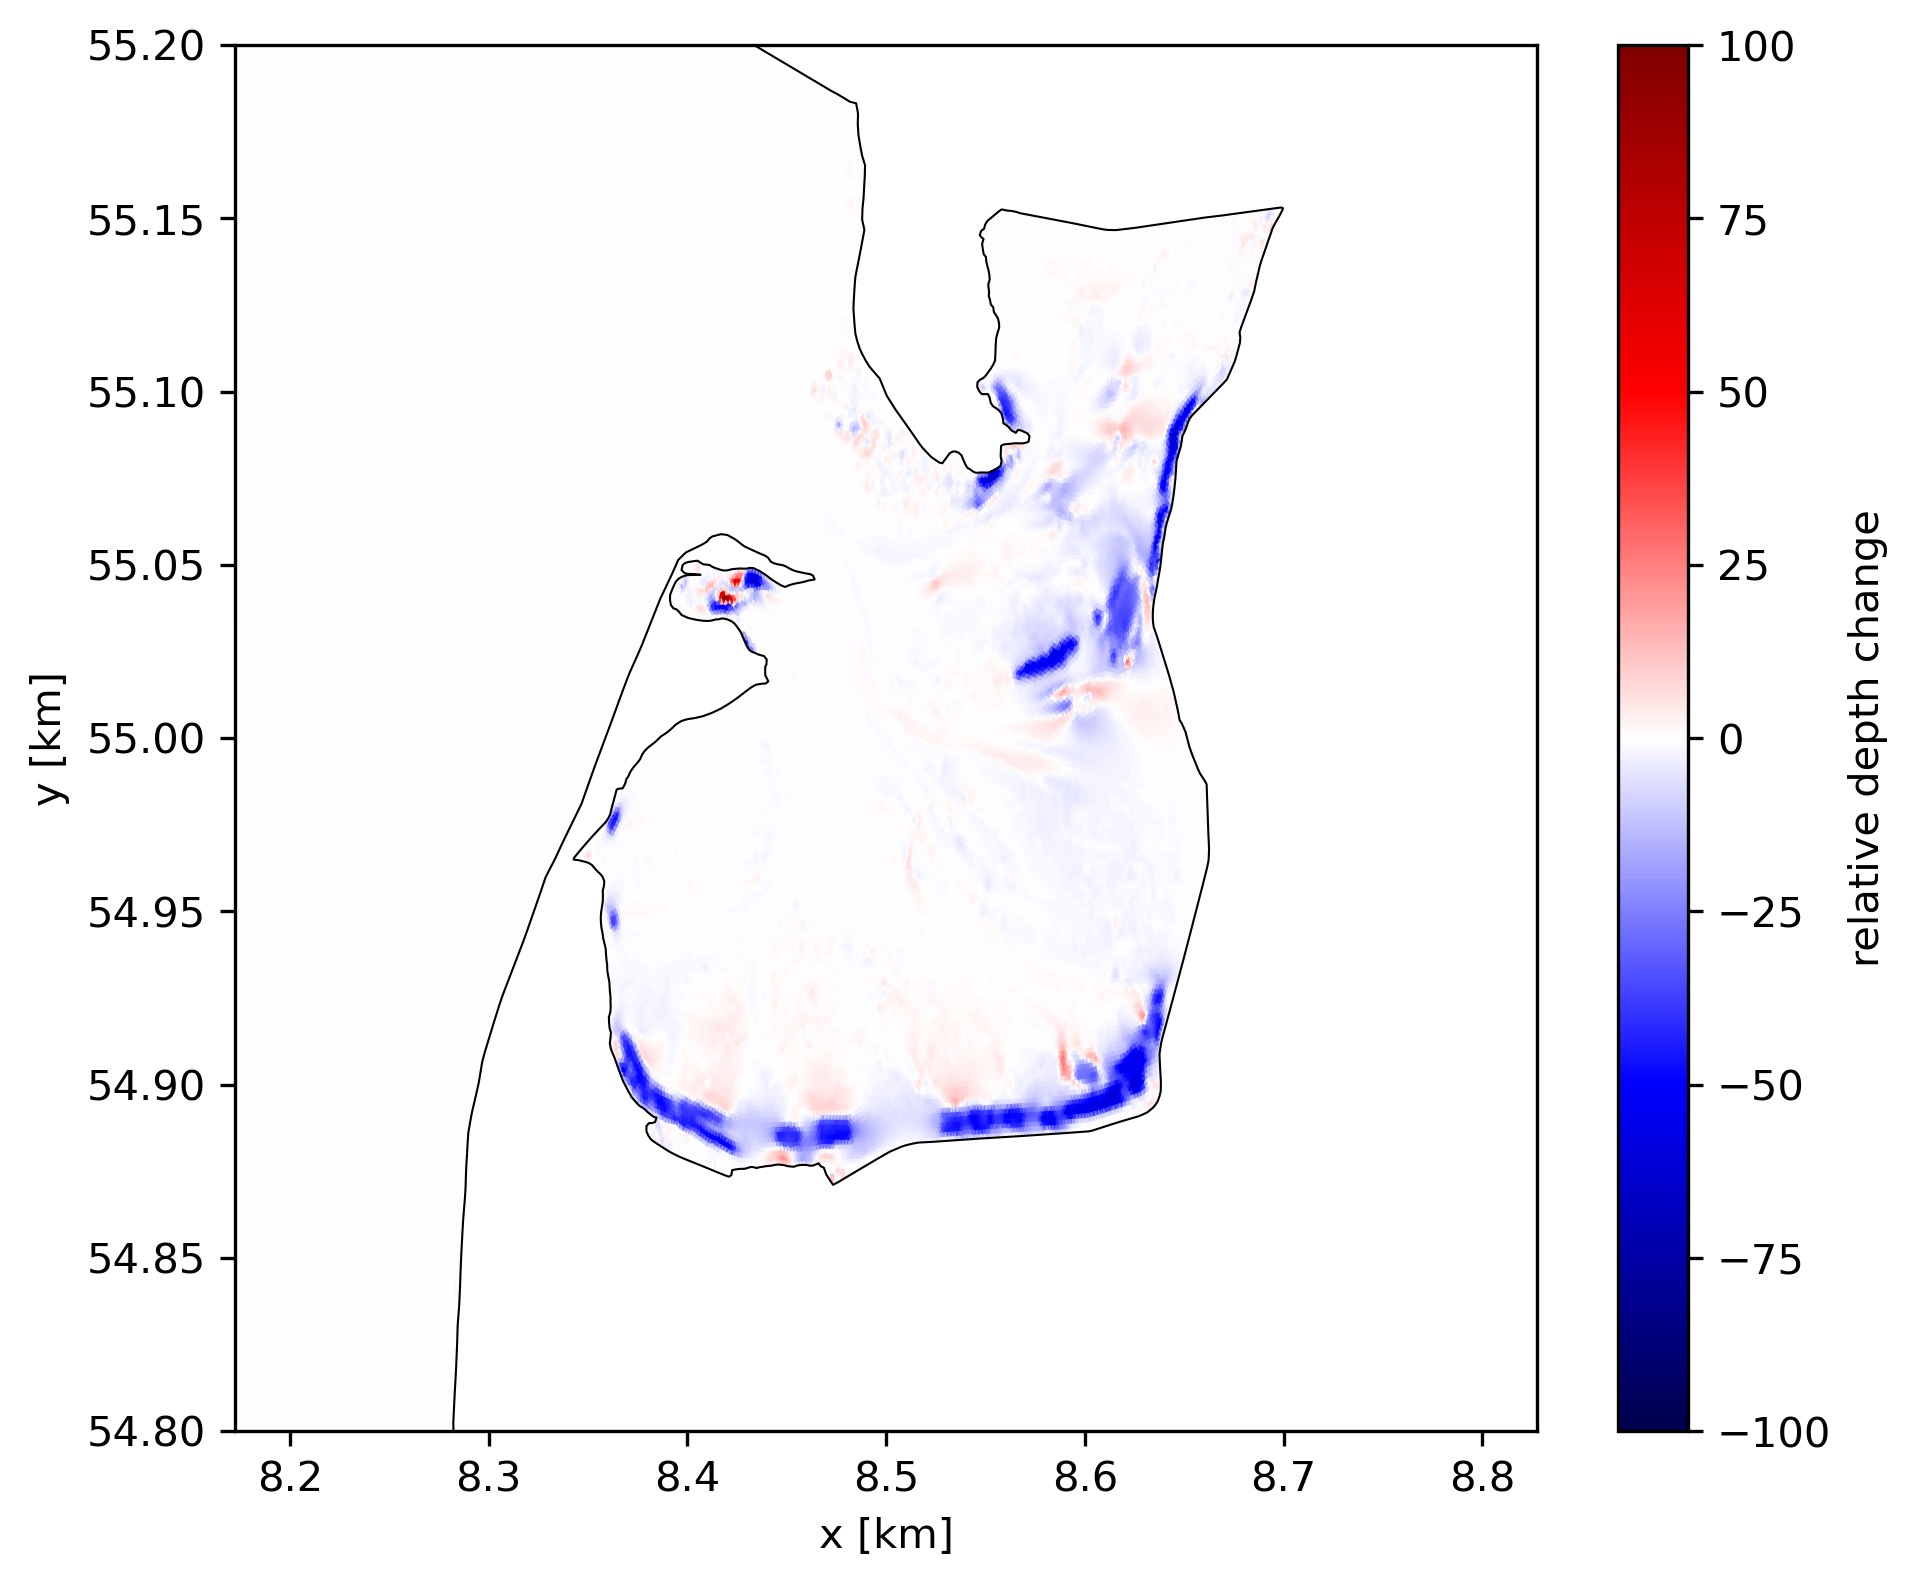

In [10]:
#depth 
fig = plt.figure(figsize=(7,6))
plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=-100, vmax=100)#,facecolors='none')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label('relative depth change')
#plt.title('T = ' + str(time[-1]) + ' days')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
plt.xlim(8.3,8.7)
plt.ylim(54.8,55.2)

In [11]:
delta[~np.isfinite(delta)]= 0

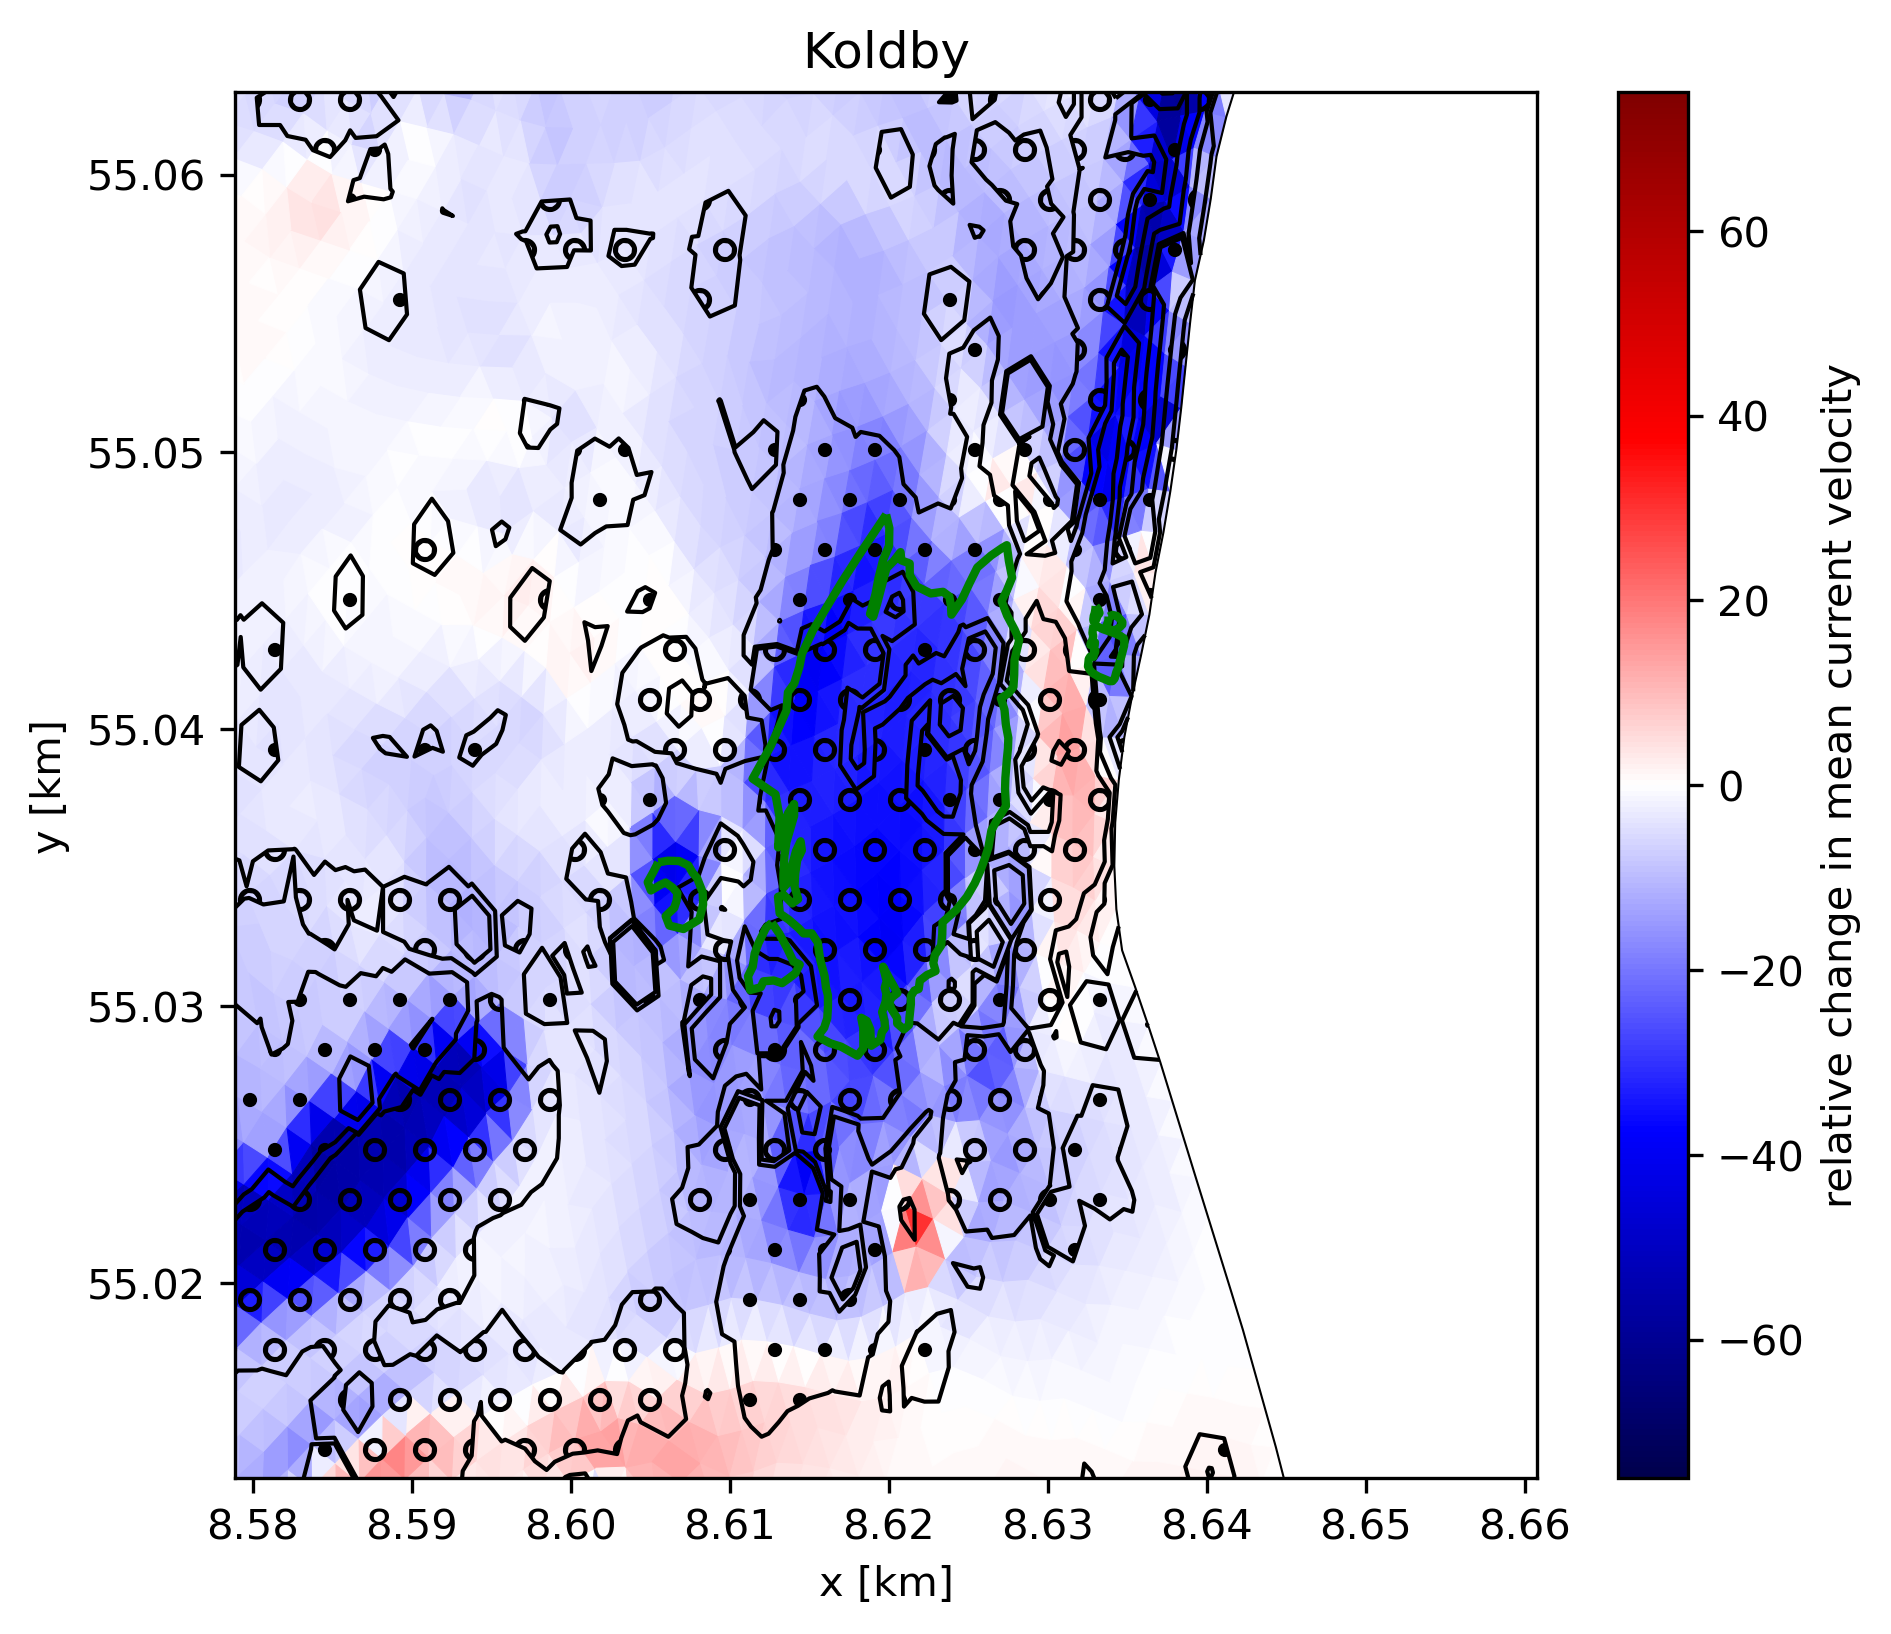

In [12]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')

sg_kold.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')


cbar.set_label('relative change in mean current velocity')
plt.title('Koldby')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.005,zorder=6,scale=35,scale_units='xy')
plt.xlim(c_kold[0]+[-dx,dx])
plt.ylim(c_kold[1]+[-dx,dx])
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_KD_'+season+'_dseas.png')

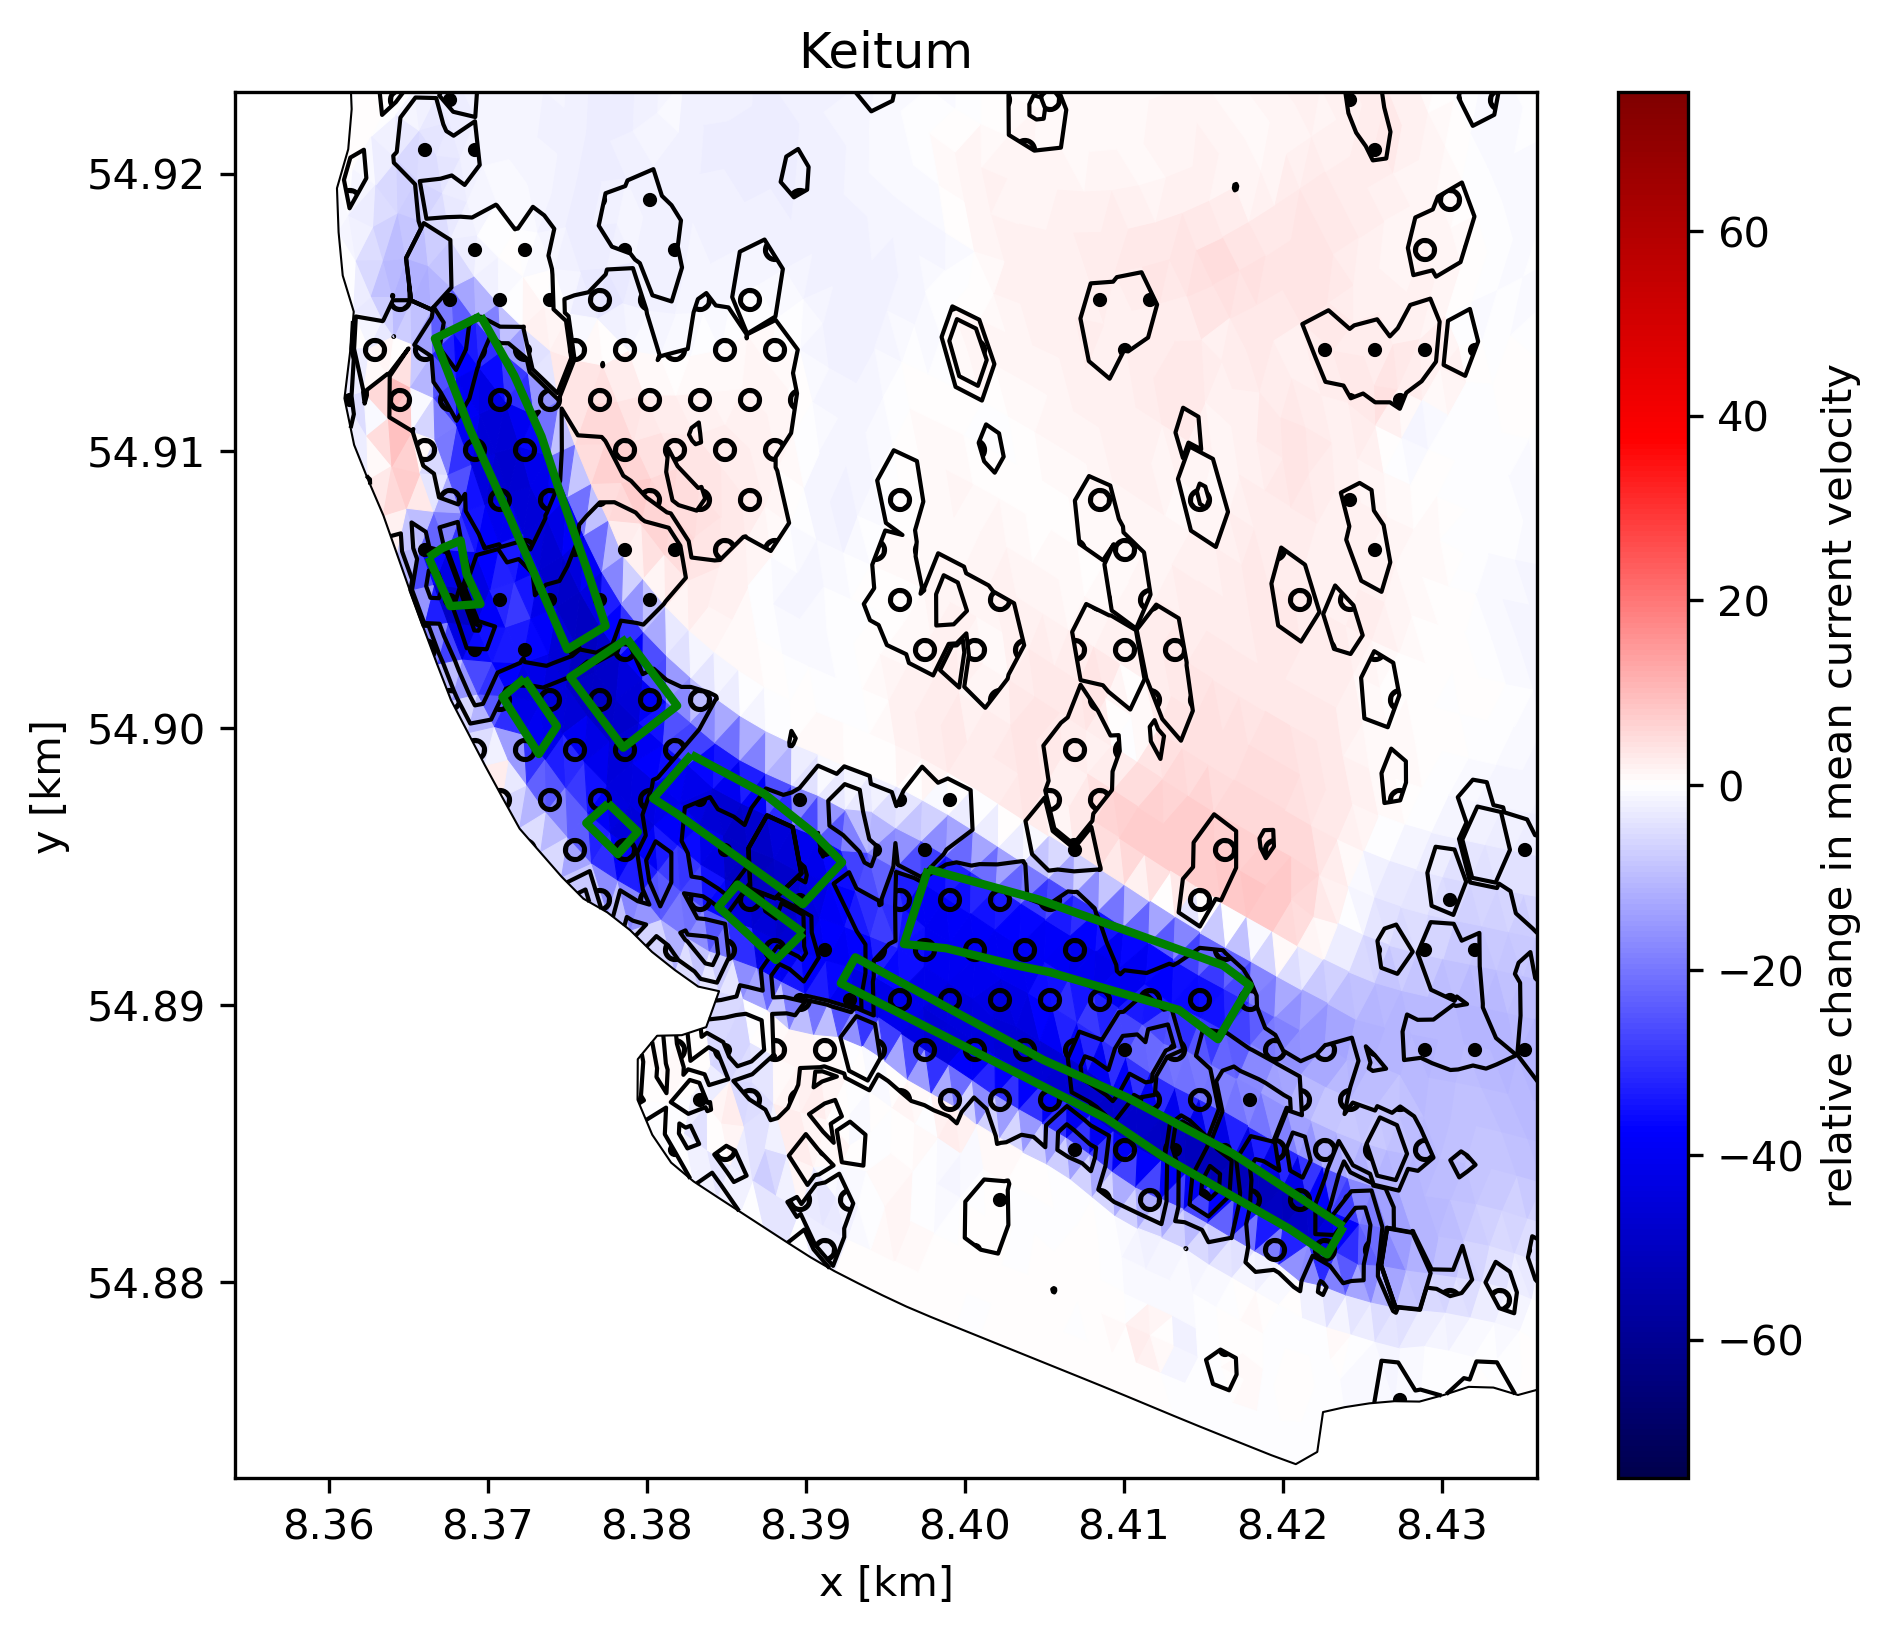

In [13]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_keit.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')


cbar.set_label('relative change in mean current velocity')
plt.title('Keitum')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.003,zorder=6,scale=20,scale_units='xy')
plt.xlim(c_keit[0]+[-dx,dx])
plt.ylim(c_keit[1]+[-dx,dx])
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_KT_'+season+'_dseas.png')

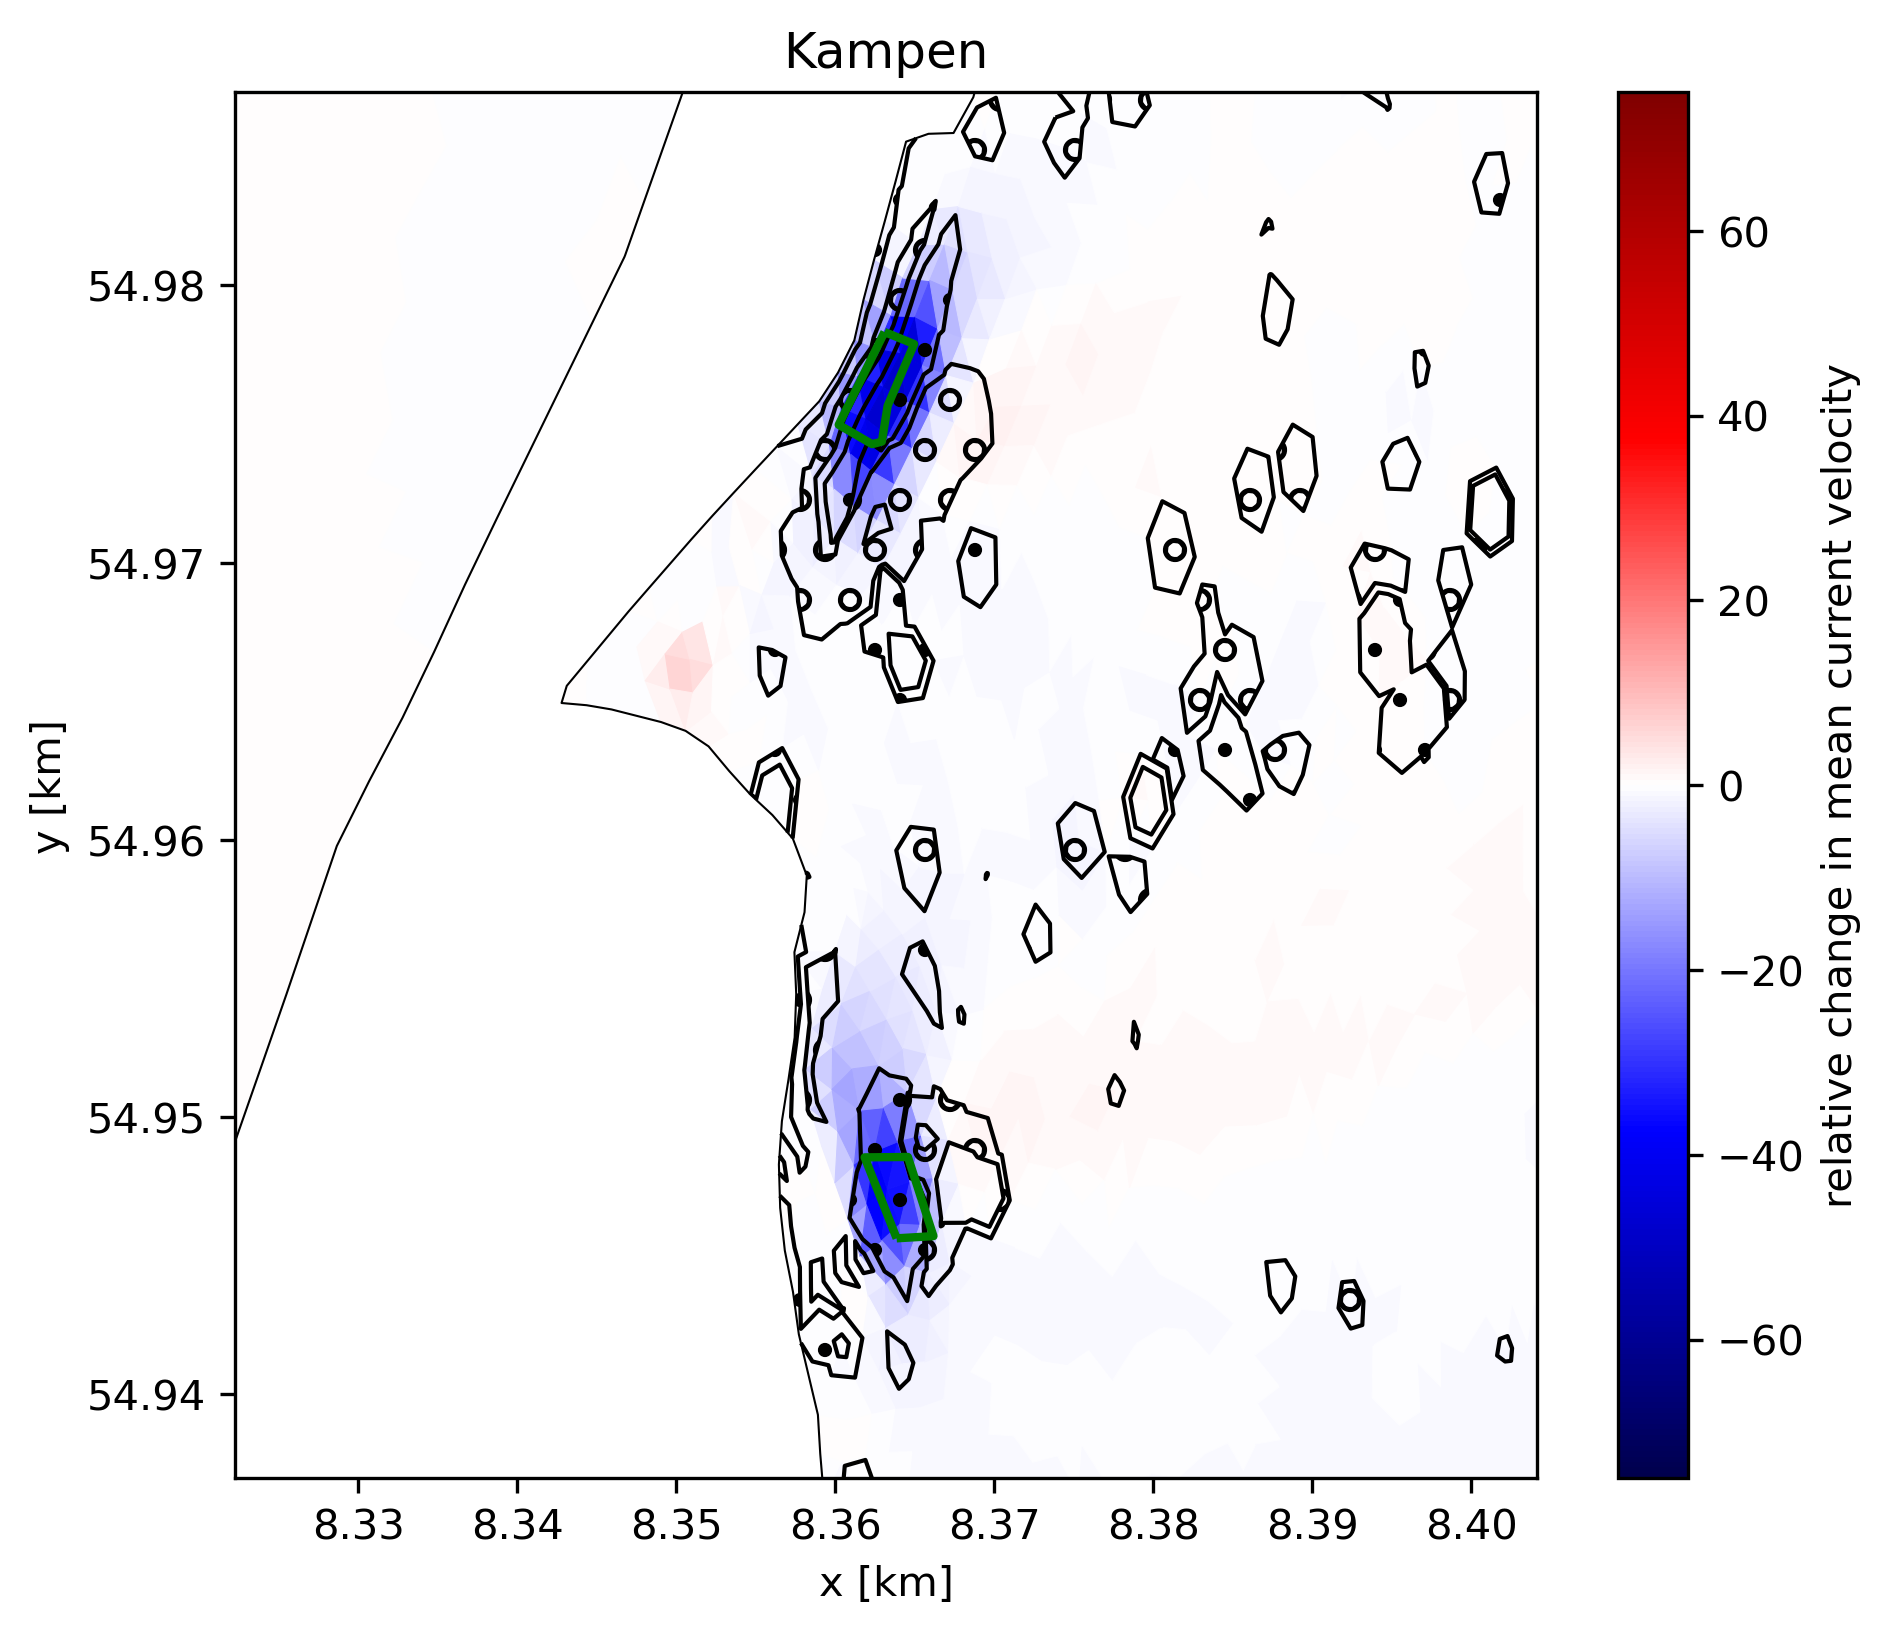

In [14]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_kamp.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_kamp[0]+[-dx,dx])
plt.ylim(c_kamp[1]+[-dx,dx])
cbar.set_label('relative change in mean current velocity')
plt.title('Kampen')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.003,zorder=6,scale=40,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_KP_'+season+'_dseas.png')

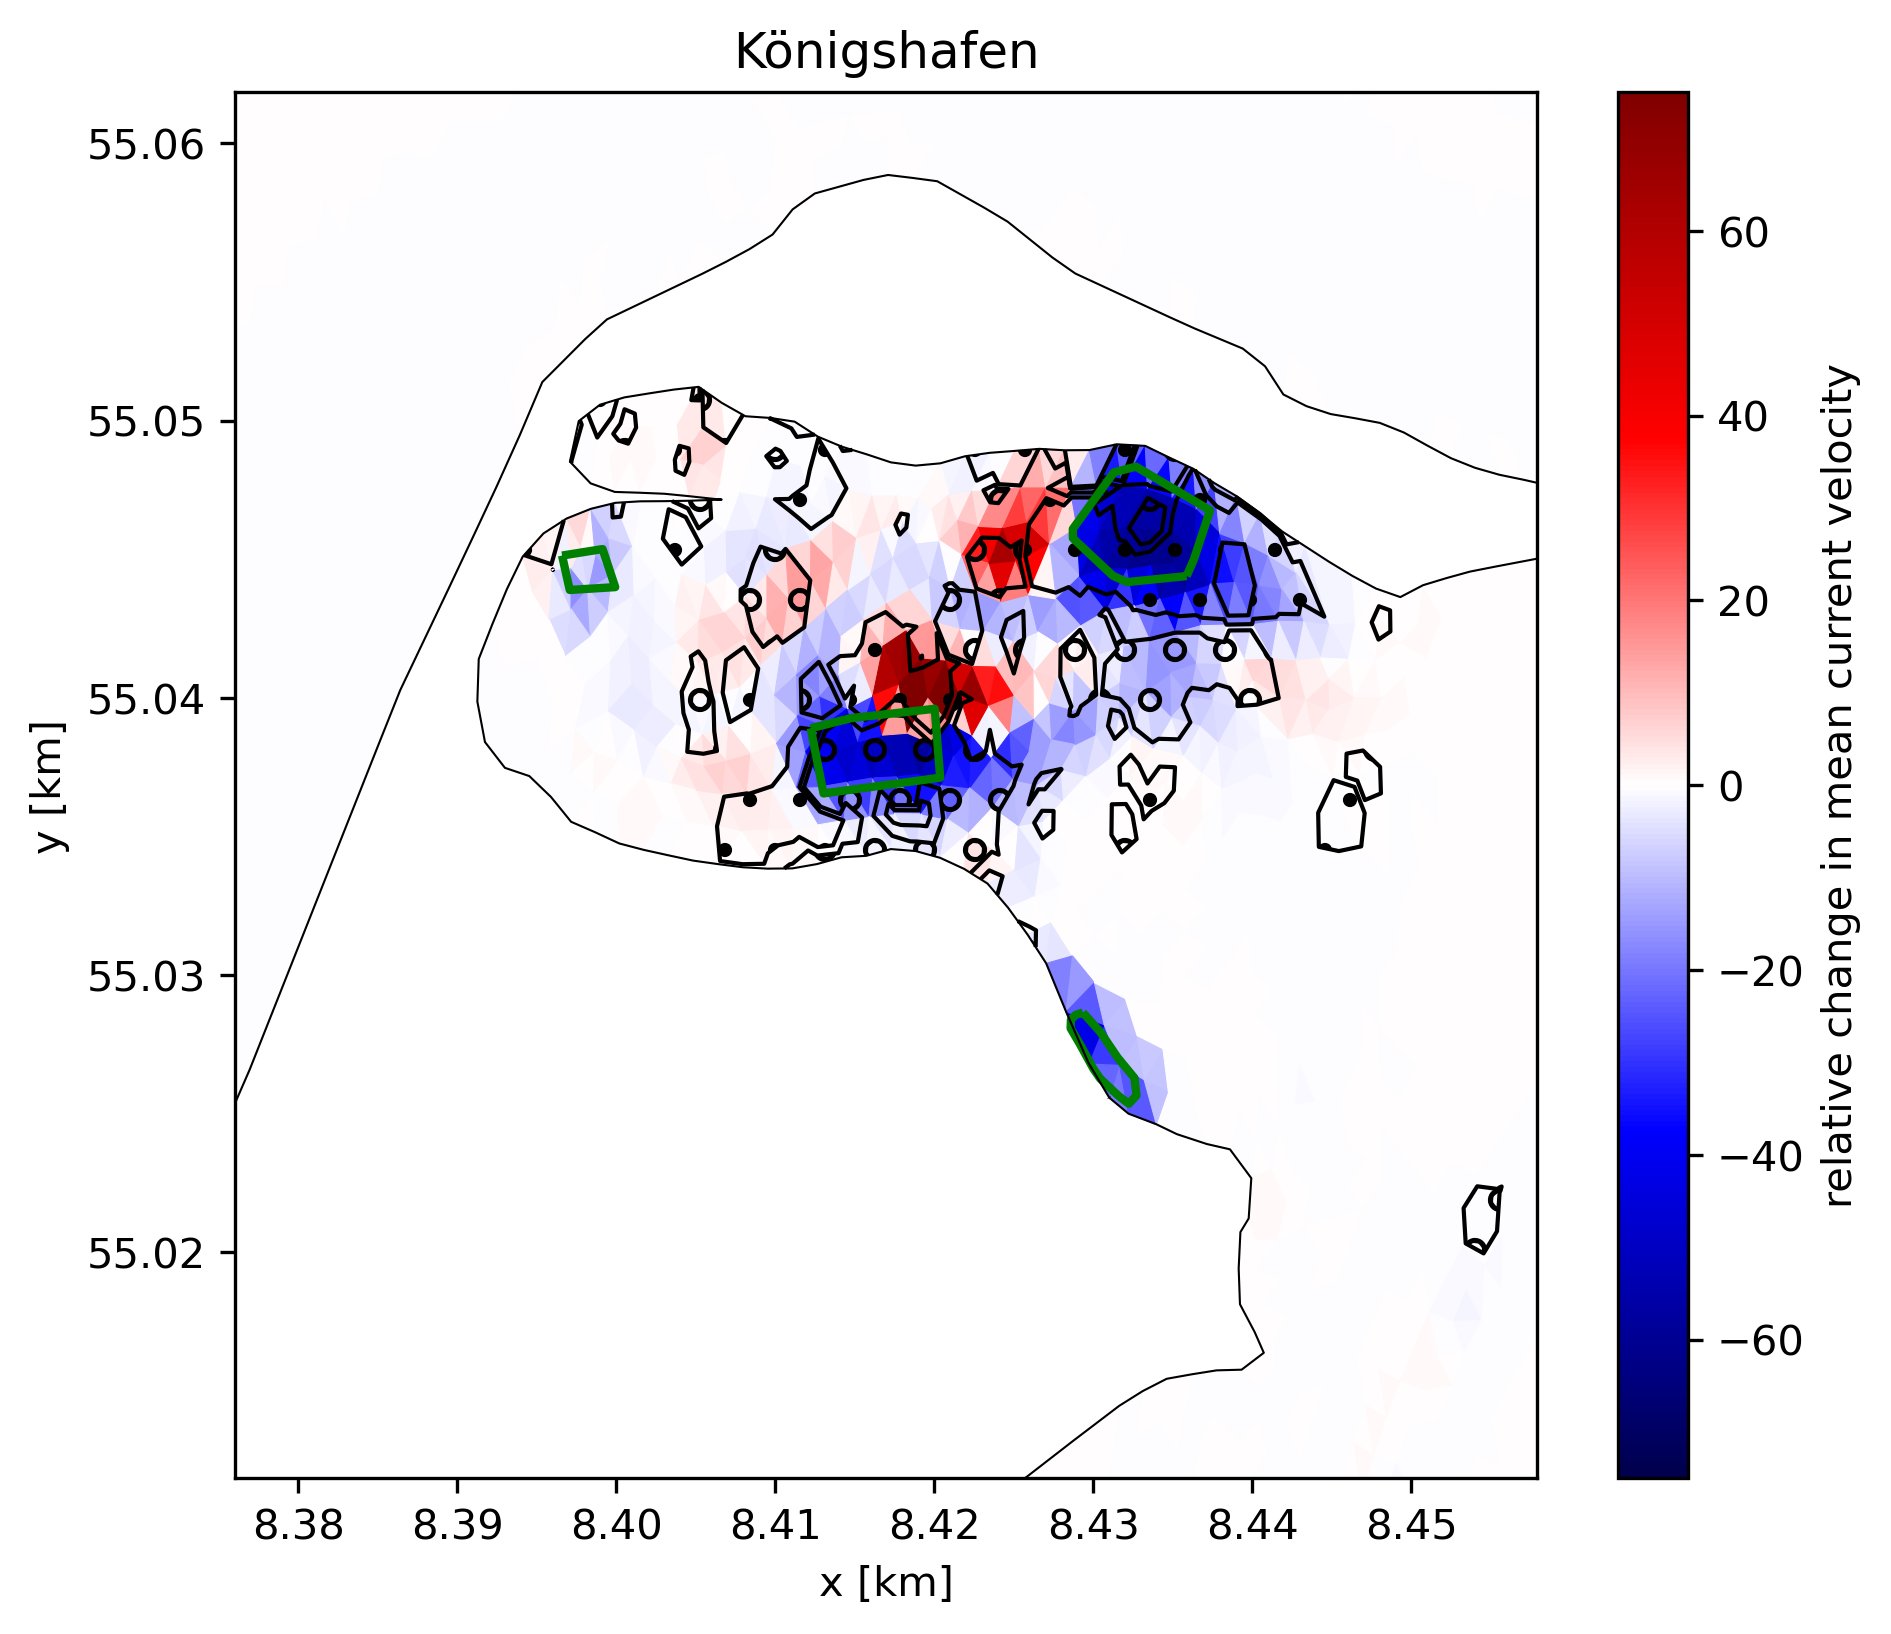

In [15]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_koen.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_koen[0]+[-dx,dx])
plt.ylim(c_koen[1]+[-dx,dx])
cbar.set_label('relative change in mean current velocity')
plt.title('Königshafen')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.004,zorder=6,scale=20,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_KH_'+season+'_dseas.png')

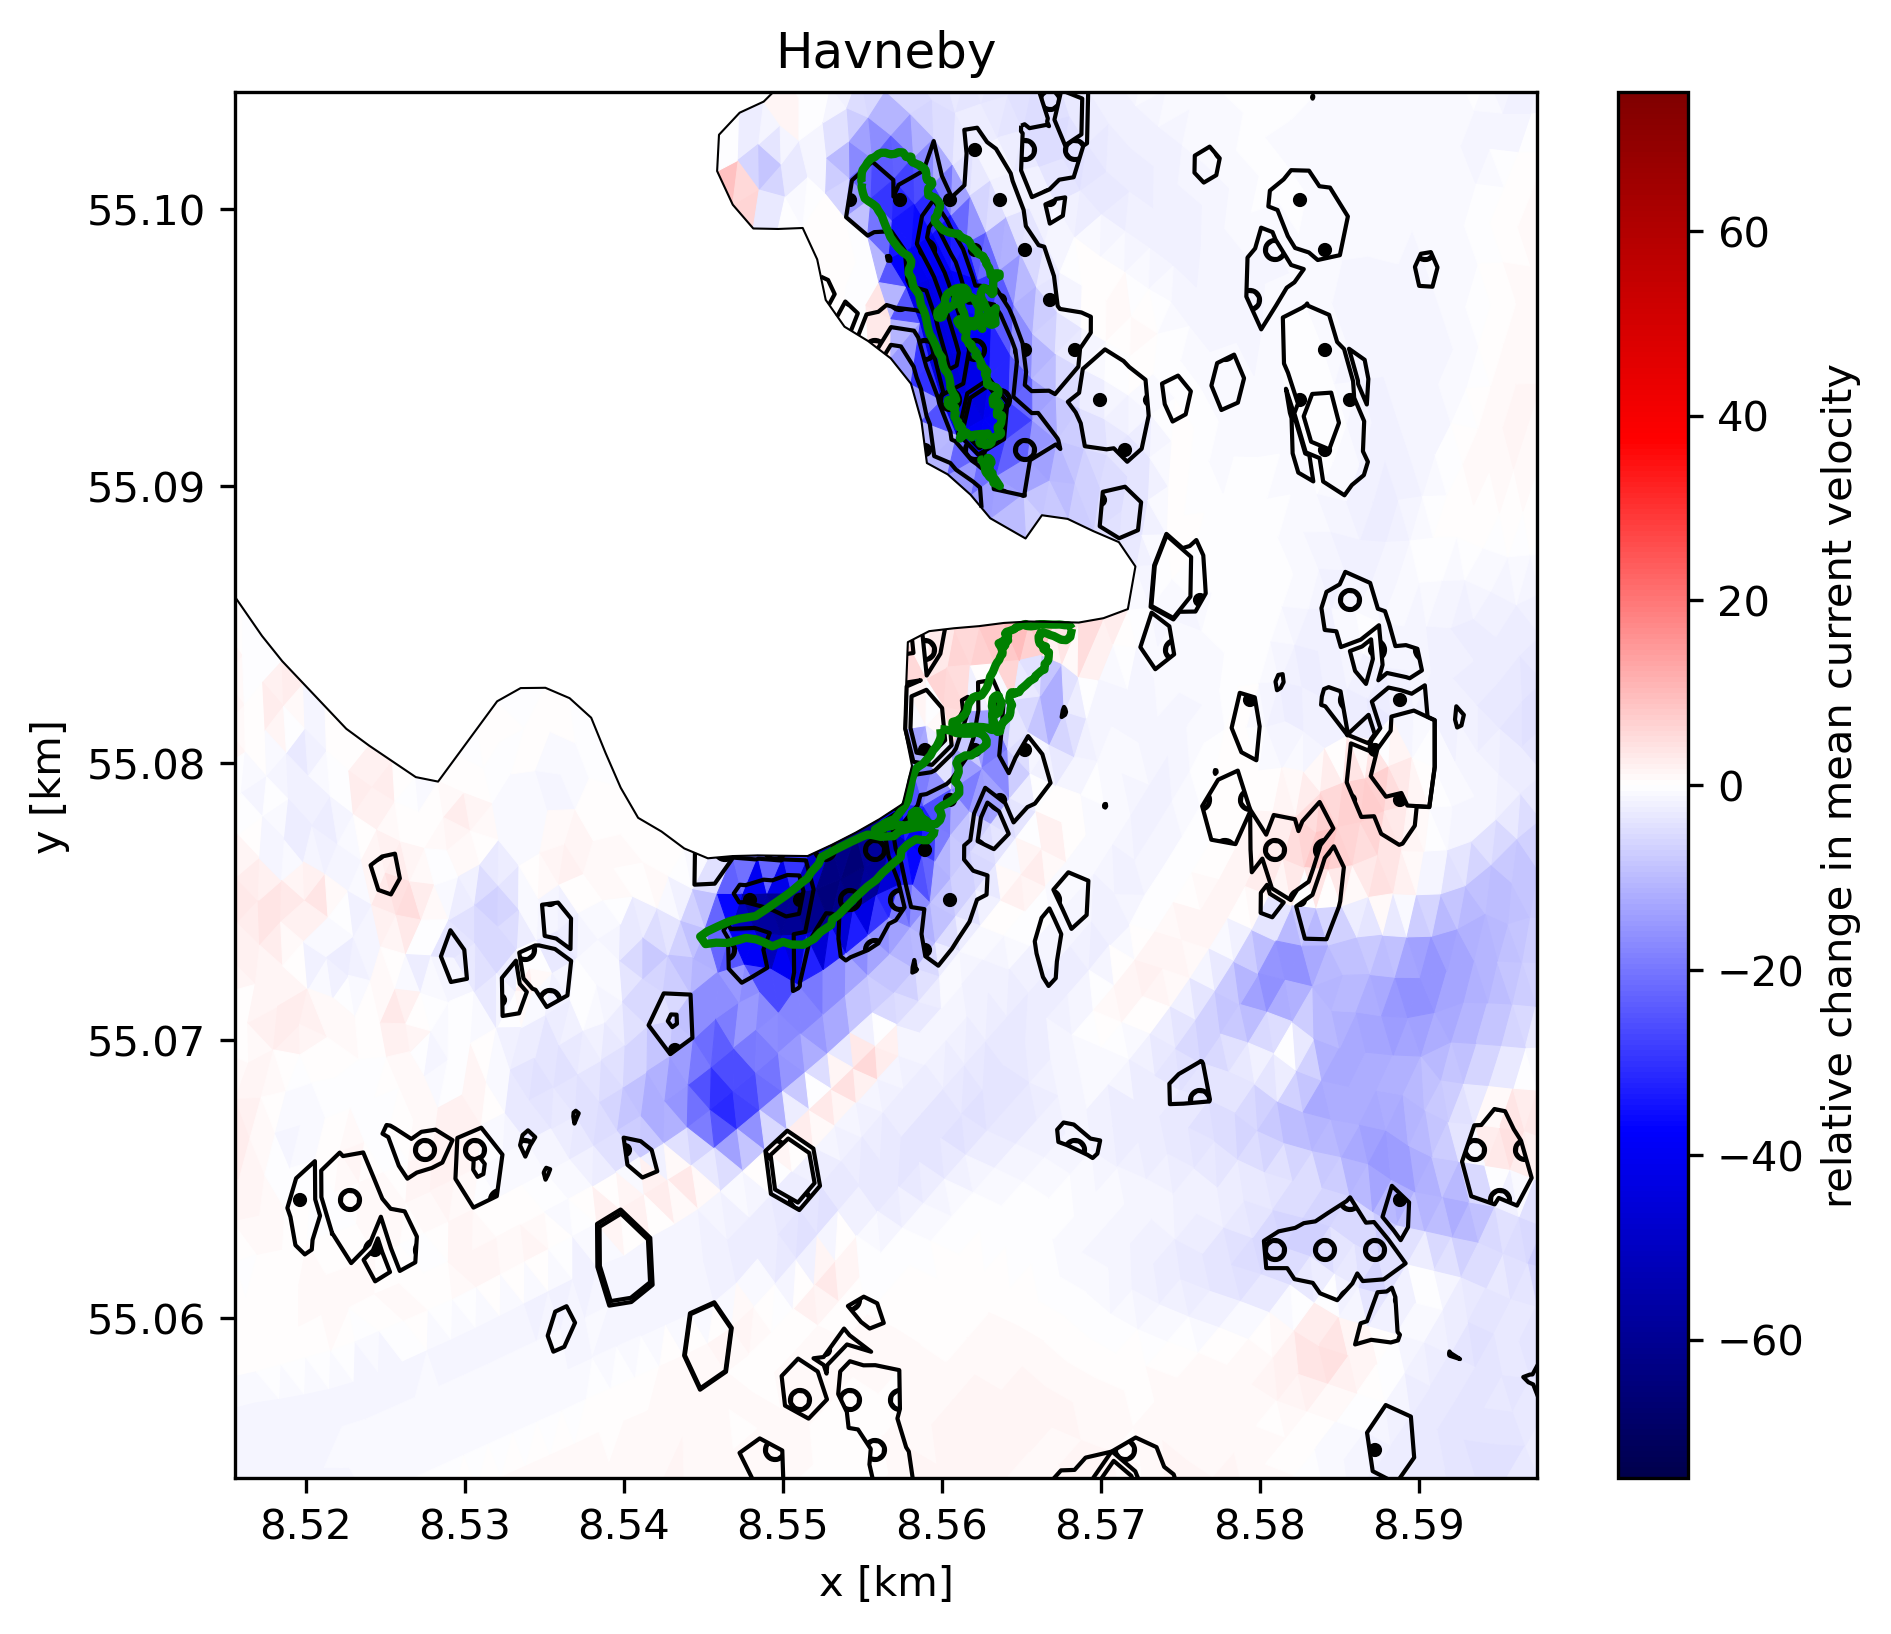

In [16]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_havn.boundary.plot(ax=plt.gca(),color='green',linewidth=2)#,hatch= "////")
sg_havs.boundary.plot(ax=plt.gca(),color='green',linewidth=2)#,hatch= "////")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_havs[0]+[-dx,dx])
plt.ylim(c_havs[1]+[-dx,dx])

cbar.set_label('relative change in mean current velocity')
plt.title('Havneby')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean1,y_mean1,width=0.005,zorder=6,scale=20,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_HAV_'+season+'_dseas.png')

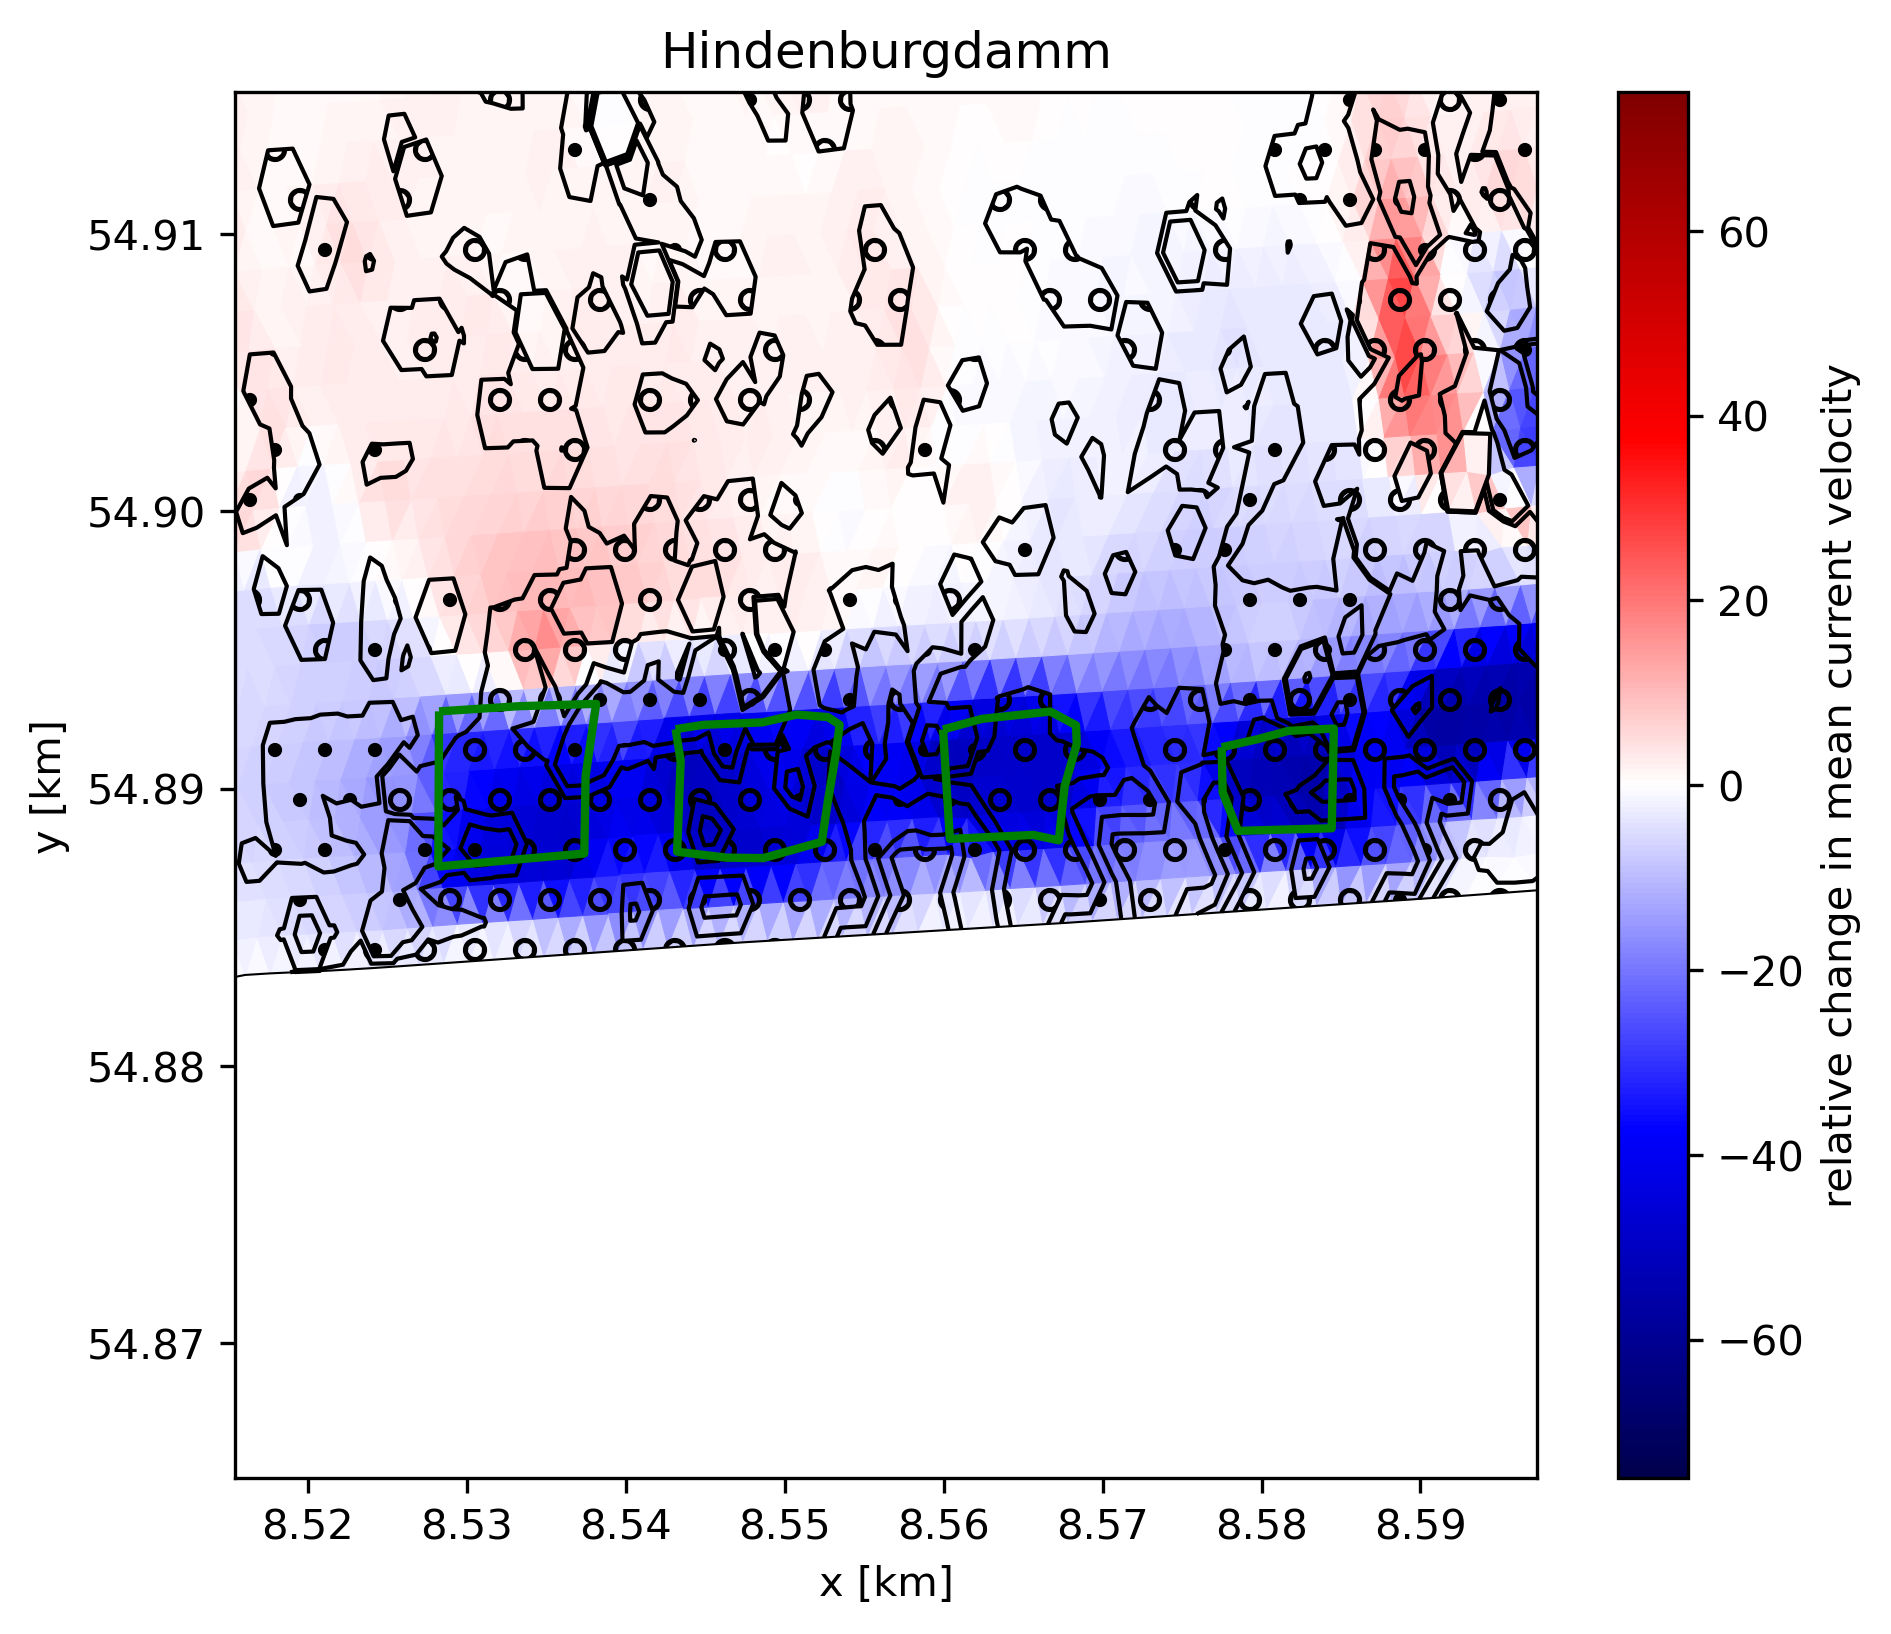

In [17]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_hind.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_hind[0]+[-dx,dx])
plt.ylim(c_hind[1]+[-dx,dx])

cbar.set_label('relative change in mean current velocity')
plt.title('Hindenburgdamm')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.003,zorder=6,scale=25,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_HD_'+season+'_dseas.png')

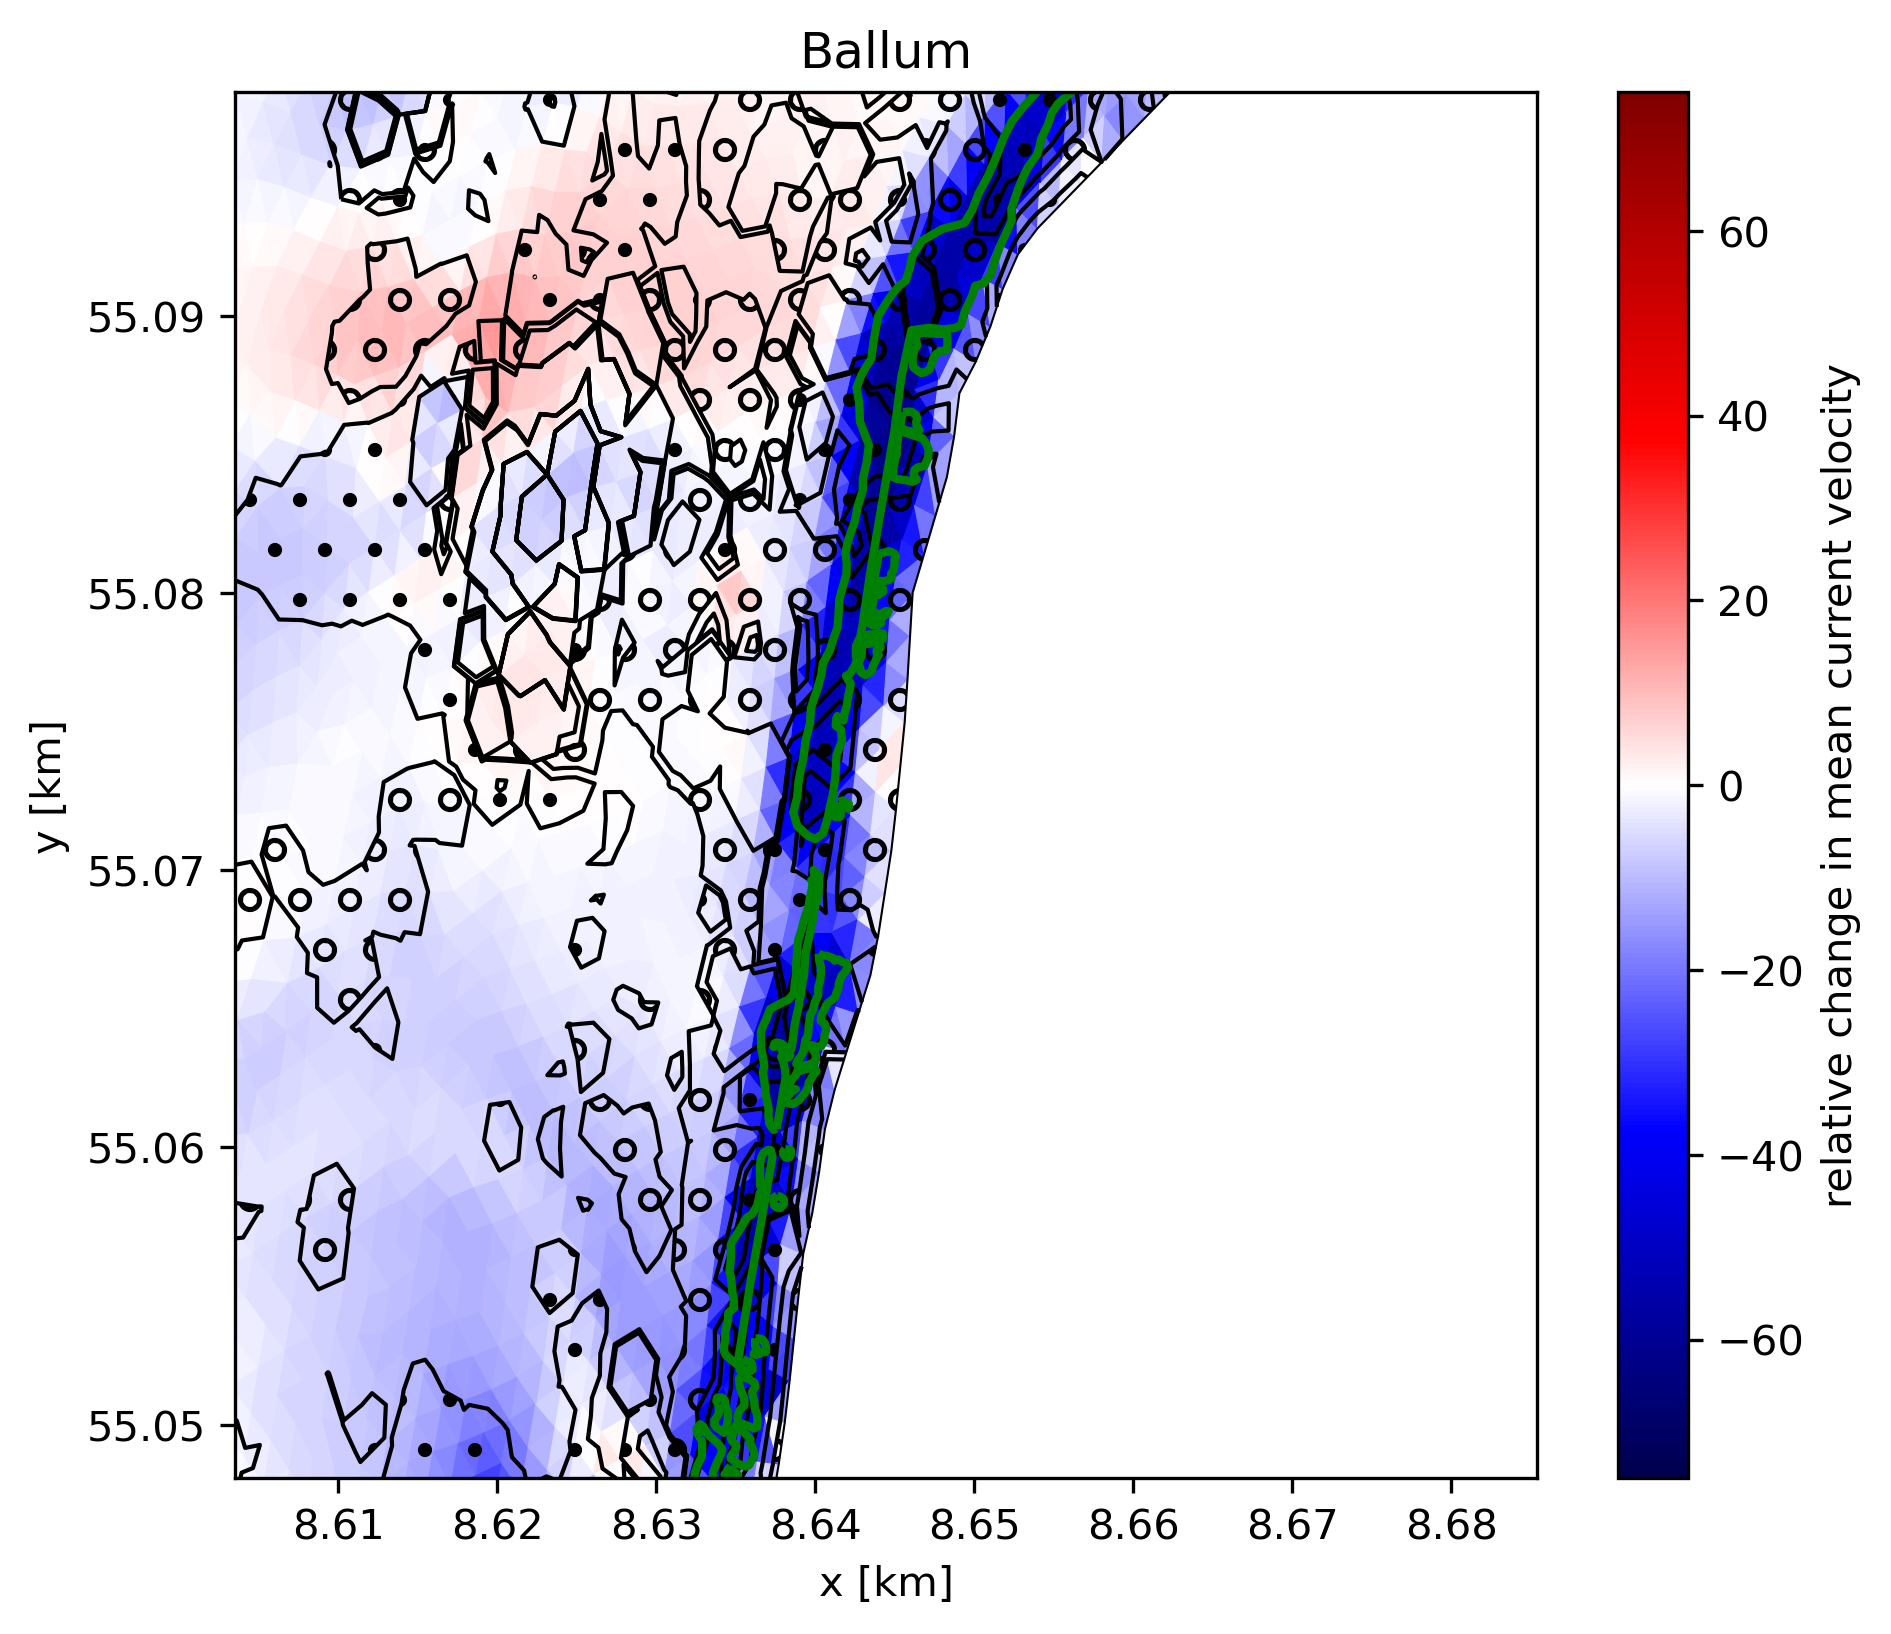

In [18]:

fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_ball.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_ball[0]+[-dx,dx])
plt.ylim(c_ball[1]+[-dx,dx])

cbar.set_label('relative change in mean current velocity')
plt.title('Ballum')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.002,zorder=6,scale=20,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_BAL_'+season+'_dseas.png')

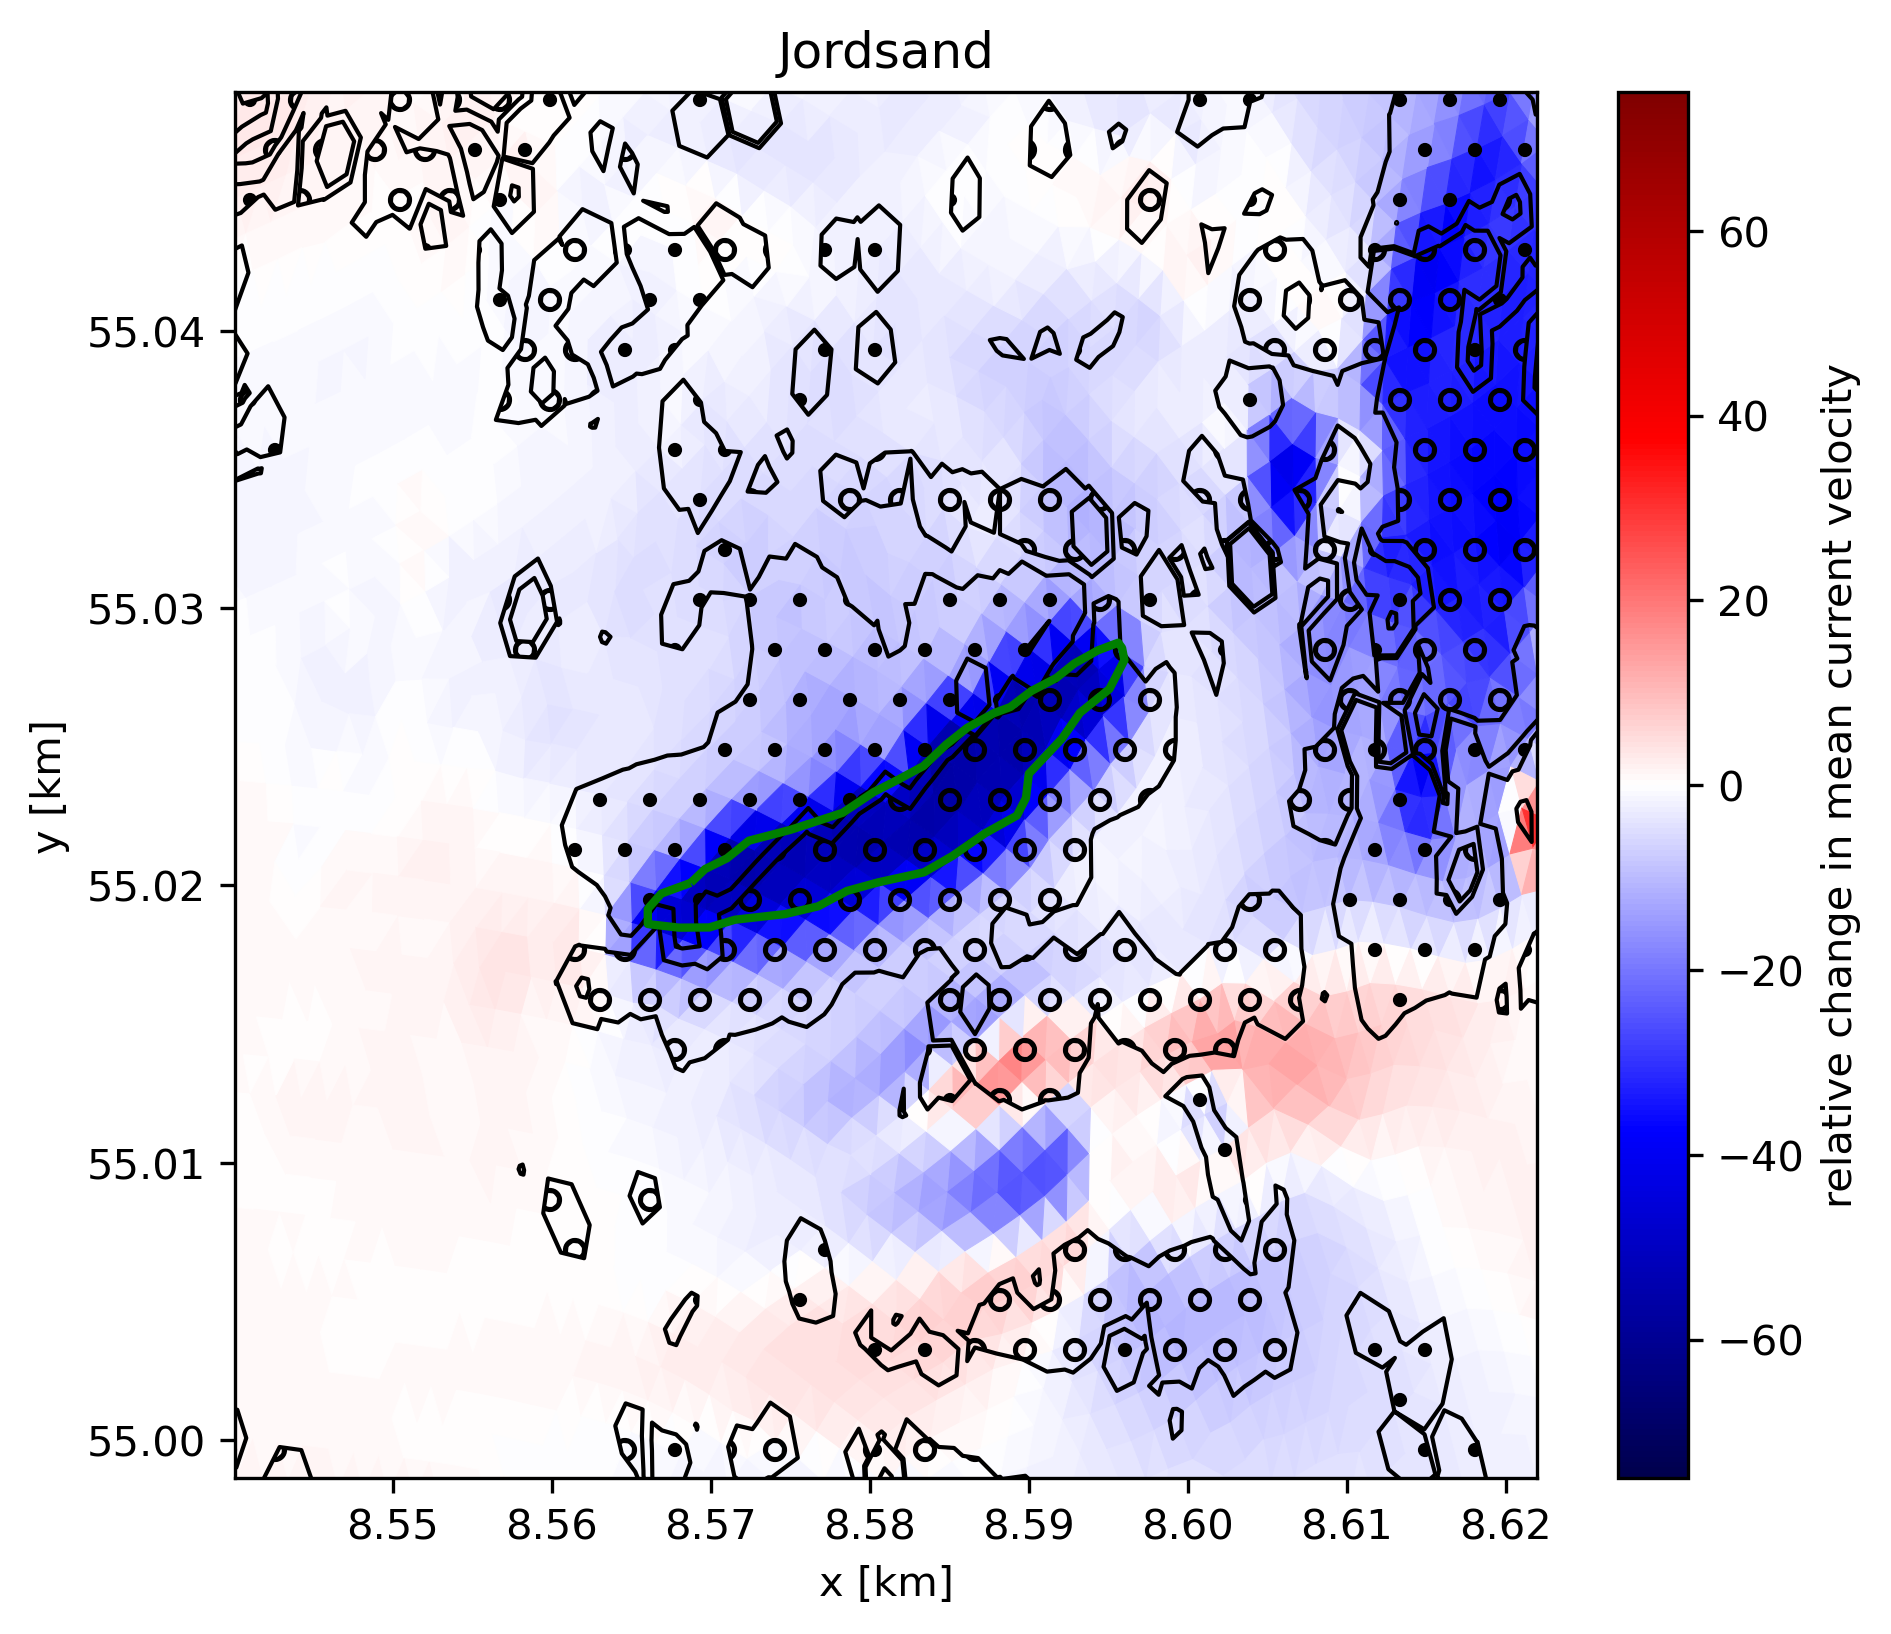

In [19]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_jord.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_jord[0]+[-dx,dx])
plt.ylim(c_jord[1]+[-dx,dx])

cbar.set_label('relative change in mean current velocity')
plt.title('Jordsand')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.005,zorder=6,scale=20,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_JS_'+season+'_dseas.png')

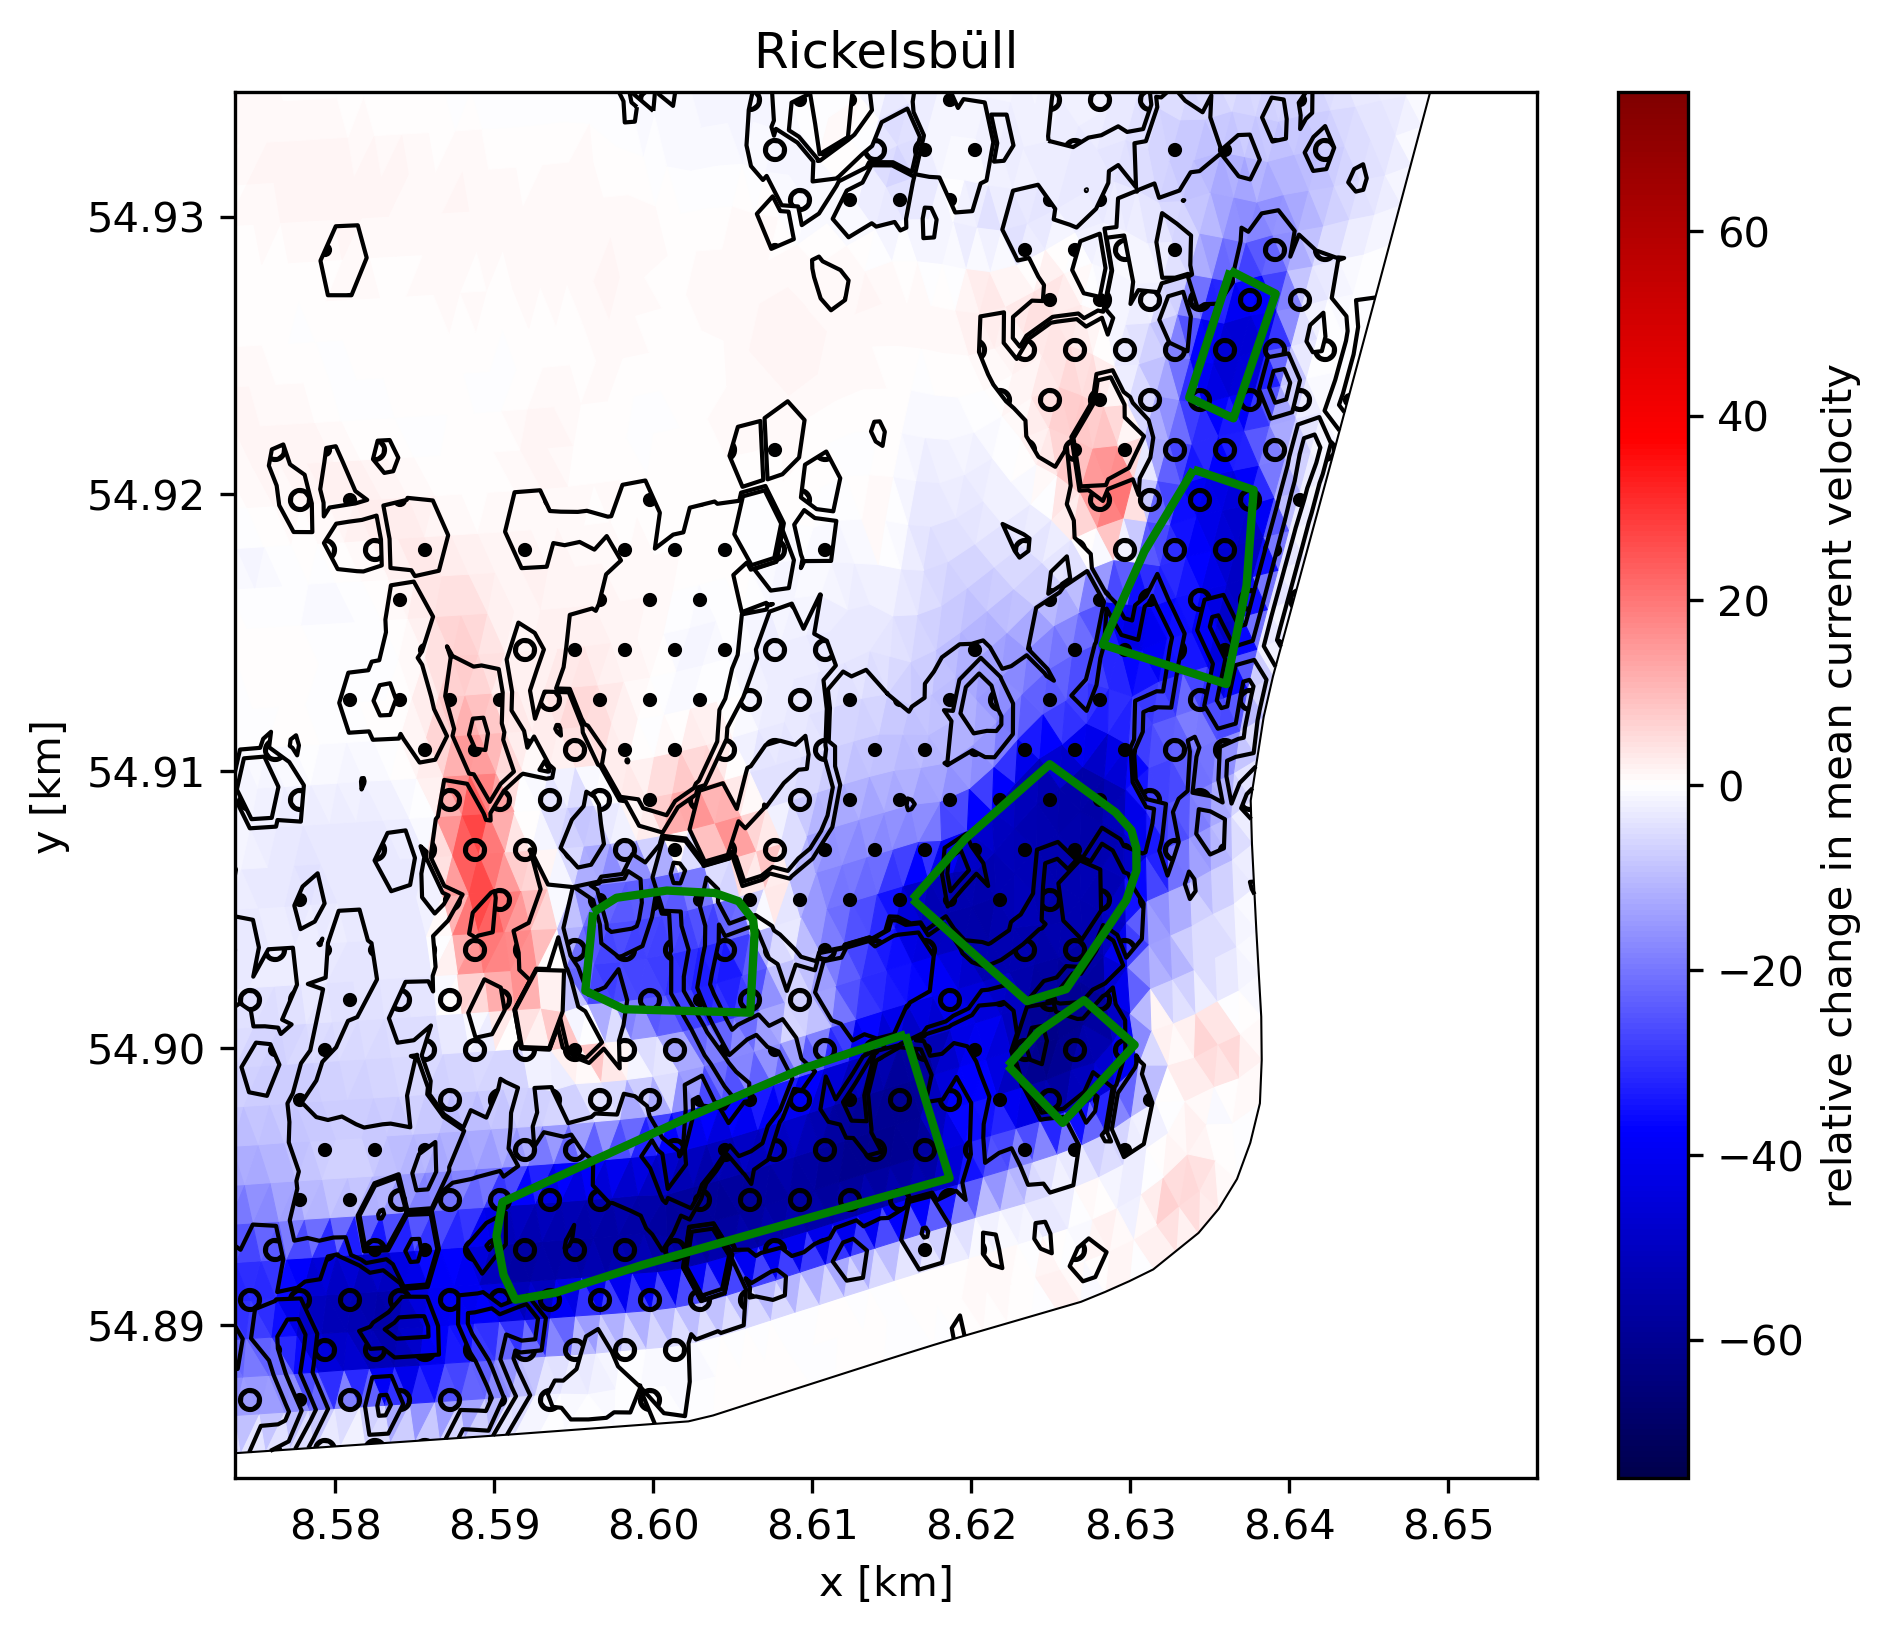

In [20]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_rick.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_rick[0]+[-dx,dx])
plt.ylim(c_rick[1]+[-dx,dx])

cbar.set_label('relative change in mean current velocity')
plt.title('Rickelsbüll')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.0025,zorder=6,scale=25,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_RB_'+season+'_dseas.png')

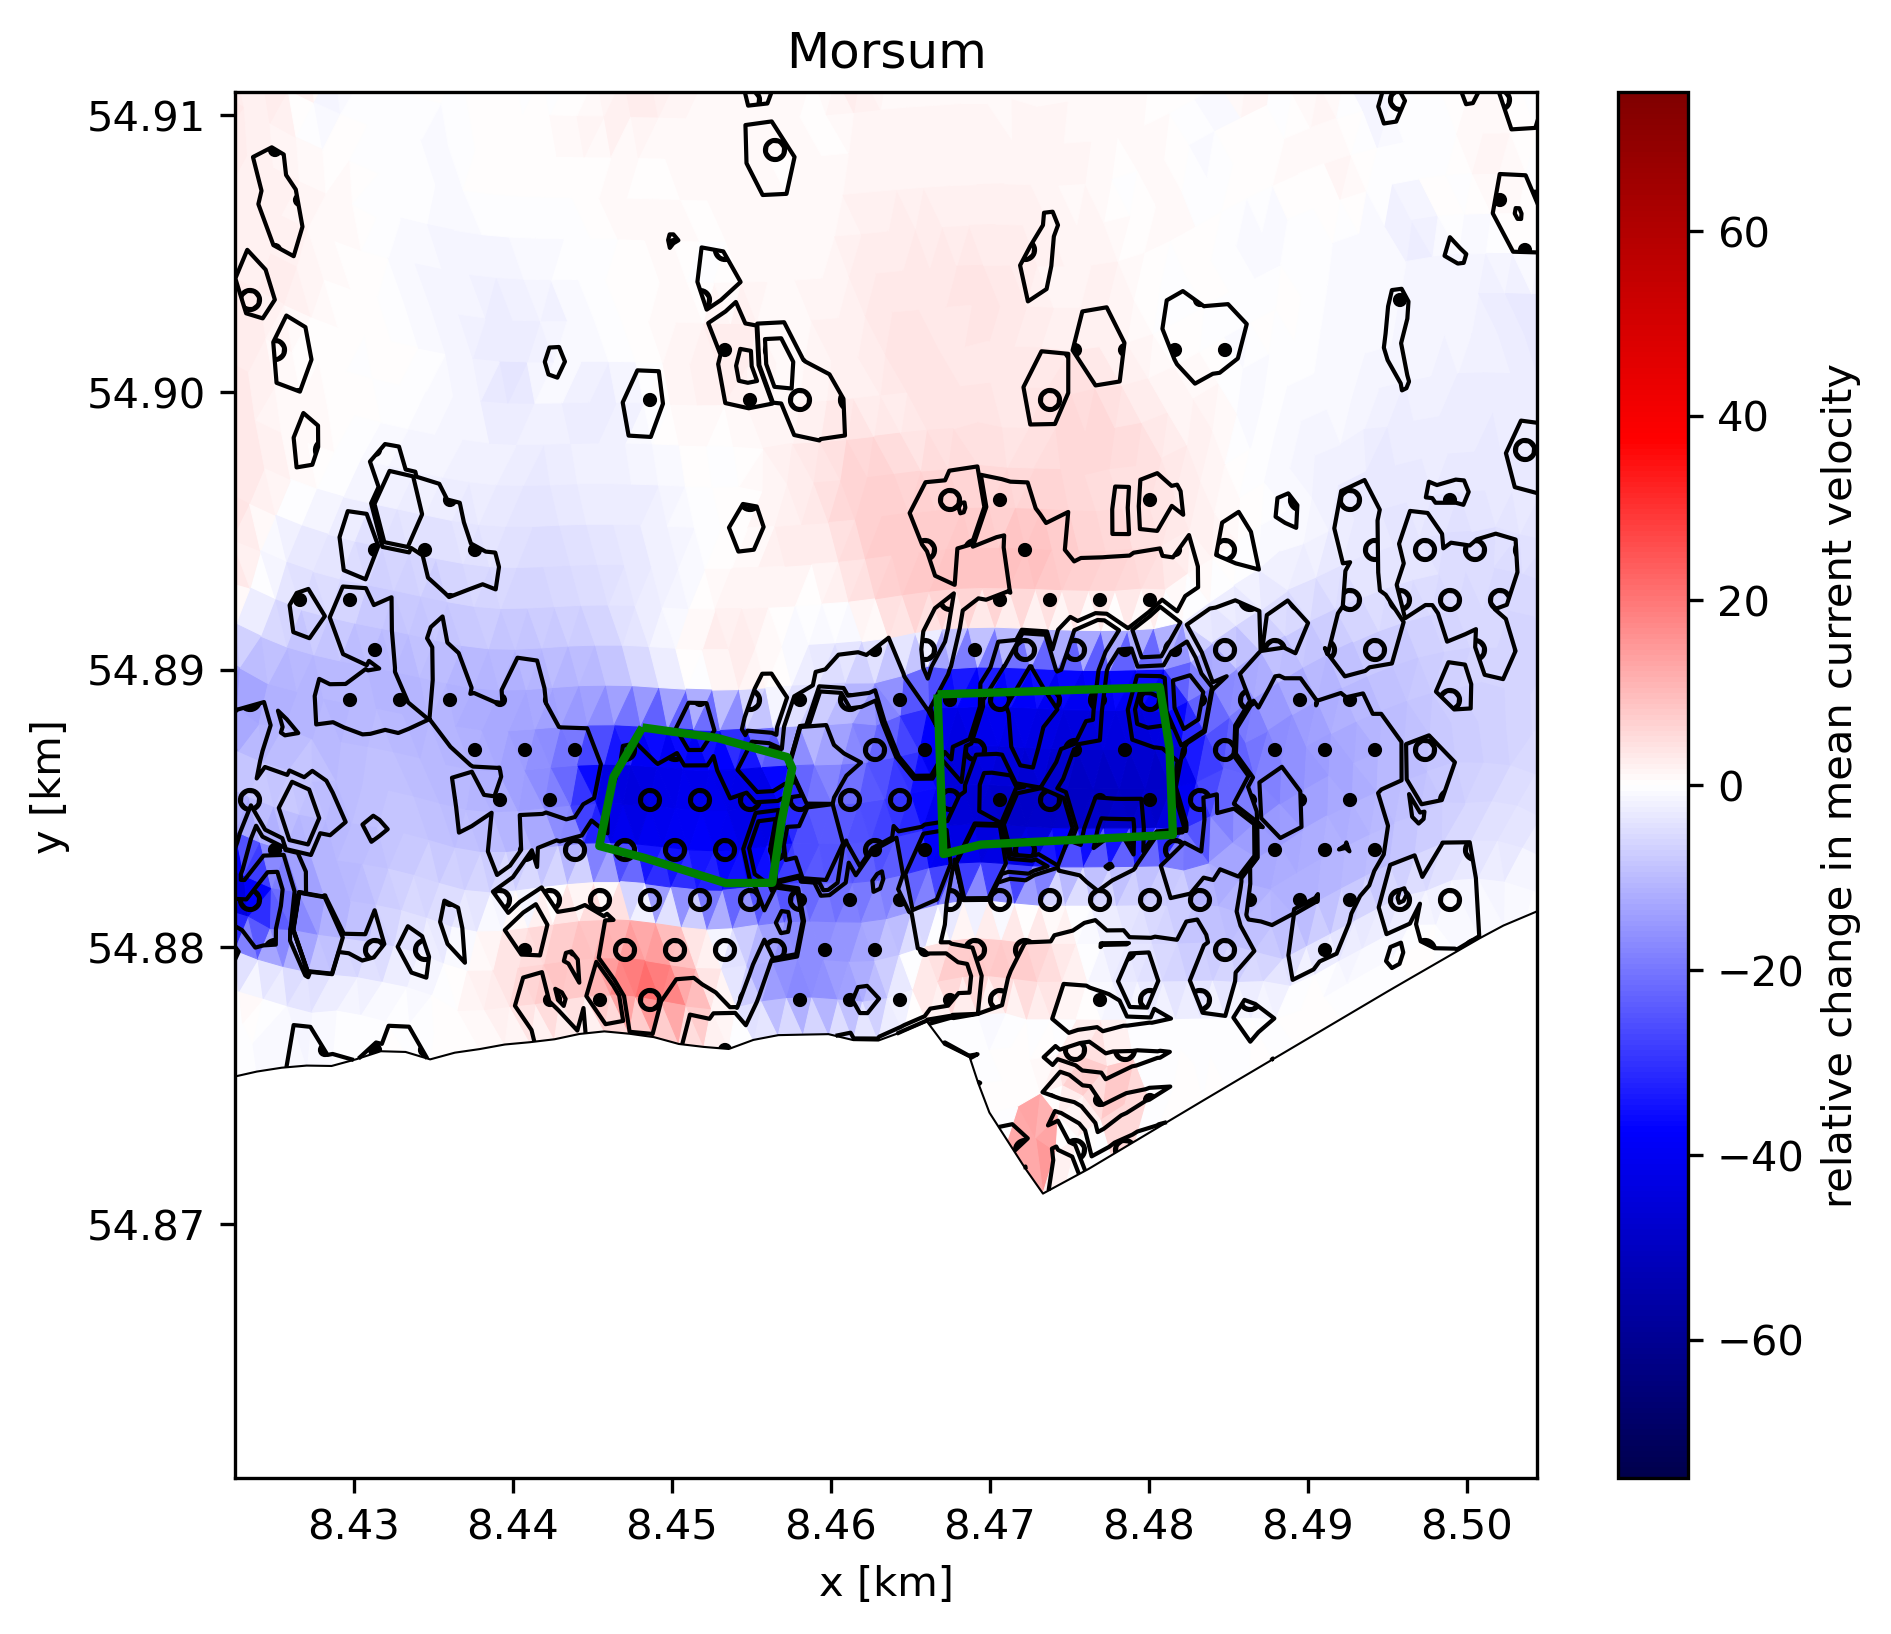

In [21]:
fig = plt.figure(figsize=(7,6))

plt.tripcolor(x, y, tri, deltav, cmap='seismic',edgecolors='face',vmin=svmin, vmax=svmax)#,facecolors='none')
cbar = plt.colorbar()
plt.tricontour(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='k',hatches=['o',None,'.'],linewidths =1,linestyles='solid')
plt.tricontourf(x,y,tri, delta,[-1000,dmin,dmax,1000],colors='none',hatches=['o',None,'.'],linestyles='solid')
sg_mors.boundary.plot(ax=plt.gca(),color='green',linewidth=2)
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.axis('equal')
plt.xlim(c_mors[0]+[-dx,dx])
plt.ylim(c_mors[1]+[-dx,dx])

cbar.set_label('relative change in mean current velocity')
plt.title('Morsum')
shape = gpd.read_file(shp_pat)
shape.boundary.plot(ax=plt.gca(),color='k',linewidth=0.5)
#plt.quiver(x,y,x_mean,y_mean,width=0.003,zorder=6,scale=25,scale_units='xy')
plt.savefig(outpath + 'comp_vel_ero_sg_perc_' + basename1 + '_' + basename2 + '_MS_'+season+'_dseas.png')